# **CRDM Model Fit (Parameter Estimation) with** ***Real Data***
### - **Maximum Likelihood Estimation (MLE)**
- Estimates Alpha and Gamma/Mu first, then Beta second


#### **====Why bother using our own math for LL rather than Scipy's Bernoulli logpmf?====**

- Most importantly, so we can better understand the mathematical foundation of our modeling. It is necessary to understand each part so we know when and why these components may not be appropriate or even misleading.
    - Lets everyone know what's actually happening! Couldn't find docs explaining the "efficiency mechanics" of Bernoulli's logpmf, so let's investigate compare the LL outcomes:
    - Returns identical summed LL
        - log(x) * y == log(x**y)
            - If you multiply a logged value by another value (*left*), it's the same as if you exponentiated before logging (*right*)
                - *Logs are used to get the exponent required for the base to reach the input value*
                    - z = log_e(x) --> e**z = x
                        - z * y = y * log_e(x) --> e**(z*y) = x**y
                            - z * y = log_e(x**y)
        - x = prob of choosing lottery for the current condition subgroup
        - y <= number of trials per subgroup
        - Can be represented as log(x) + log(x) == 2 * log(x)
            - log(x) was originally part of log(x**2)
        - *Works regardless of number of trials per subgroup*
    - Bernoulli:
        - log(x) + log(x) + log(x[y number of times])
    - Manual:
        - log(x) * y

In [ ]:
## Demonstration ##
import numpy as np
from scipy.stats import bernoulli

MLL_trials = np.array([2.0, 1.0, 1.0]) ## (y) each value represents the sum of lottery choices in that condition subgroup | number of trials per subgroup = 2
MLL_probs  = np.array([1.0, 0.5, 0.7]) ## (p) probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
MLL_total_trials = np.array([2, 2, 2]) ## (previously 1) number of trials per subgroup
print("No black box LL:    ", np.nansum(np.log(MLL_probs) * MLL_trials + np.log(1 - MLL_probs) * (MLL_total_trials - MLL_trials)))

BLL_trials = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
BLL_probs  = np.array([1.0, 1.0, 0.5, 0.5, 0.7, 0.7])
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(BLL_trials, BLL_probs)))

In [1]:
"""
===================
Mandy Renfro (2024)
===================
"""

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all = "ignore")
import os
import os.path, sys
import pandas as pd
import seaborn as sns
sns.set_theme(style="white", palette="muted")
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

base_proj_dir = "Z:/data/RIC" ## base project directory
data_dir = "Z:/data/RIC/sourcedata/RIC1" ## directory containing data

def goodness_of_fit(max_LL, choices, n = 1, num_params = 3):
    """Calculates goodness of fit metrics (R Squared and AIC) 
        INPUT
        - max_LL: maximum likelihood score associated with best fit parameters
        - choice:
        - n: each row containing a single trial
        - num_params: number of free parameters (alpha, beta, & gamma)
        OUTPUT
        - R2: proportion of variance in the observed data that is explained by the parameters
        - AIC: Akaike Information Criterion for current model
        - AIC0: Akaike Information Criterion for strawman model
    """
    maximum_LL = max_LL
    strawman_MLL = np.nansum(np.log(0.5) * choices + np.log(1 - 0.5) * (n - choices))
    R2 = np.round(1 - (maximum_LL/strawman_MLL), 3) 
    AIC = np.round((2 * num_params) - (2 * maximum_LL), 3)
    AIC0 = np.round((2 * 0) - (2 * strawman_MLL), 3)
    return R2, AIC, AIC0


def pd_extend(df_dest, df_extending):
    """ Concatenates all subjects dataframe for saving current Ss parameters
        INPUT
        - df_dest: destination dataframe to which second dataframe will be appended
        - df_extending: dataframe to be added to the destination dataframe
        OUTPUT
        - Concatenated dataframe containing info from currently iterated Ss
    """
    return pd.concat([df_dest, df_extending])


def SV(alpha, beta, lottery_value, certain_value, ambiguity, probability):
    """ Calculate SV for lottery and safe options (Gilboa & Schmeidler, 1989)
        **Note: np.sign() and np.abs() allows flexible handling for *both* gain/loss
        INPUT
        - alpha: current Ss alpha
        - beta: current Ss beta
        - lottery_value: winning lottery amount
        - ambiguity: ambiguity level
        - probability: probability level
        OUTPUT
        - SV_lottery: subjective value for lottery option
        - SV_certain: subjective value for certain option
    """
    SV_lottery = (probability - beta * ambiguity / 2) * np.sign(lottery_value) * (np.abs(lottery_value)**alpha)
    SV_certain = np.sign(certain_value) * (np.abs(certain_value)**alpha)
    return SV_lottery, SV_certain

## **===Softmax Choice Function===**

In [6]:
def binomial_likelihood_SM(alpha, beta, gamma, y, n, lottery_value, certain_value, ambiguity, probability):
    """ Calculates binomial LL for each parameter combination.
        *See above notes for why we can use our own math rather than rely on bernoulli.logpmf()
        *Deals with positive infinity values by assigning a value of 0, 
        then during MLE functions, parameter pairs with 0 LL score are removed
        INPUT
        - alpha: current Ss risk parameter [high values indicate risk seeking]
        - beta: current Ss ambiguity parameter [high values indicate ambiguity avoidance]
        - gamma: current Ss choice stochasticity parameter [high values indicate more noise]
        - y: summation of lottery choices
        - n: number of trials
        - lottery_value: all lottery values for risk or ambiguity trials 
        - certain_value: all safe values for risk or ambiguity trials 
        - ambiguity: all ambiguity values for risk (amb = 0) or ambiguity trials
        - probability: all probability values for risk or ambiguity (prob = 0.5) trials
        OUTPUT
        - log_likelihood: relative likeliness score is probabilty observed data came from parameters
    """
    p = probability_of_lottery_choice_SM(alpha, beta, gamma, lottery_value, certain_value, ambiguity, probability)
    log_likelihood = (np.log(p) * y + np.log(1 - p) * (n - y))
    log_likelihood[log_likelihood == np.inf] = 0
    return log_likelihood


def fit_data_SM(data, domain, pid, df):
    """ (1) Calls MLE functions to fit model and return Alpha, Gamma, and Beta parameters
        (2) Creates dataframe for saving parameter estimates
        INPUT
        - data: current Ss dataframe containing trial data (domain, prob, amb, sure_amt, lott_amt, choice) 
        - domain: run separately for gain/loss trials 
        - pid: current subject ID
        - df: dataframe (df_participants) to which the current Ss data will be appended
        OUTPUT
        - *res: packed variable representing current Ss alpha, beta, and gamma for gain or loss domain
        - df: df_participants appended to include Ss fitted parameters
    """
    choices = data["choice"].values
    lotteries = data["lott_amt"].values
    certain_values = data["sure_amt"].values
    ambiguities = data["amb"].values/100
    probabilities = data["prob"].values/100
    res = MLE_alpha_gamma_SM(choices, lotteries, certain_values, ambiguities, probabilities)
    res, max_LL = MLE_beta_SM(choices, res[0], res[1], lotteries, certain_values, ambiguities, probabilities)
    gof = goodness_of_fit(max_LL, choices)
    df = pd_extend(df, pd.DataFrame(np.array([pid, domain, *res, np.round(max_LL, 3), *gof]).reshape(1, -1), 
                                    columns = df.columns))
    return *res, df


def MLE_alpha_gamma_SM(choices, lotteries, certain_values, ambiguities, probabilities):
    """ Grid search of alpha and gamma parameter space to determine which point produces max log likelihood score. 
        *Risk trials only*
        *Notes: Conceptualize parameter and probability space as two parallel multidimensional spaces. 
                Using a "grid search" method, we carefully iterate through a 2D parameter space (alpha/gamma) 
                to determine which point best explains the data, quantified as the maximum likelihood score.
        INPUT
        ** Numpy parallel arrays **
        - choices: Ss choices (~80 initially, but filtered down to ~50 risk trials)
        - lotteries: winning lottery amounts (~80 initially, but filtered down to ~50 risk trials)
        - certain_values: certain amounts (~80 initially, but filtered down to ~50 risk trials)
        - ambiguities: ambiguity level (~80 initially, but filtered down to ~50 risk trials)
        - probabilities: probability level (~80 initially, but filtered down to ~50 risk trials)
        OUTPUT
        - best_fit: Tuple containing best fit parameters (alpha and gamma)
    """
    best_fit = None
    max_likelihood = None
    x, n = choices, np.ones(choices.shape)
    idx = np.where(ambiguities == 0) ## only risk trials
    for alpha in np.round(np.arange(0.1, 2, 0.01), 2): ## Grid Search 1 (search through 2D: alpha and gamma)
        for gamma in np.round(np.arange(0.01, 8, 0.01), 2):
            ## Summation log likelihood for all trials (beta/ambiguity held constant at 0 | only risk trials)
            likelihood = np.nansum(binomial_likelihood_SM(alpha, 0, gamma, x[idx], n[idx], lotteries[idx], 
                                                            certain_values[idx], ambiguities[idx], probabilities[idx]))
            if max_likelihood is None or likelihood > max_likelihood:
                max_likelihood = likelihood
                best_fit = (alpha, gamma)
    return best_fit


def MLE_beta_SM(choices, alpha, gamma, lotteries, certain_values, ambiguities, probabilities):
    """ Grid search of beta parameter space to determine which point produces max log likelihood score. 
        *Ambiguity trials only*
        *Notes: Conceptualize parameter and probability space as two parallel multidimensional spaces. 
                Using a "grid search" method previously to determine the best fit of alpha and gamma parameters, 
                we can use those values to now guide our search through 1D beta space.
        INPUT
        ** Numpy parallel arrays **
        - choices: Ss choices (~80 initially, but filtered down to ~30 ambiguity trials)
        - lotteries: winning lottery amounts (~80 initially, but filtered down to ~30 ambiguity trials)
        - certain_values: certain amounts (~80 initially, but filtered down to ~30 ambiguity trials)
        - ambiguities: ambiguity level (~80 initially, but filtered down to ~30 ambiguity trials)
        - probabilities: probability level (~80 initially, but filtered down to ~30 ambiguity trials)
        OUTPUT
        - best_fit: Tuple containing best fit parameters (alpha, beta, and gamma)
        - max_likelihood: Maximum log likelihood associated with best fit parameters
    """
    best_fit = None
    max_likelihood = None
    x, n = choices, np.ones(choices.shape)
    idx = np.where(ambiguities != 0) ## only beta trials
    for beta in np.round(np.arange(-1.3, 1.31, 0.01), 2): ## Grid Search 2 (search through 1D: beta)
        ## Summation log likelihood for all trials (pre-fit alpha/gamma informs search | only ambiguity trials)
        likelihood = np.nansum(binomial_likelihood_SM(alpha, beta, gamma, x[idx], n[idx], lotteries[idx], 
                                                        certain_values[idx], ambiguities[idx], probabilities[idx]))
        if max_likelihood is None or likelihood > max_likelihood:
            max_likelihood = likelihood
            best_fit = (alpha, beta, gamma)
    return best_fit, max_likelihood


def probability_of_lottery_choice_SM(alpha, beta, gamma, lottery_value, certain_value, ambiguity, probability):
    """ Determines probability of selecting lottery using the Softmax probabilitic function
        INPUT
        - alpha: current estimated risk parameter [high values indicate risk seeking]
        - beta: current estimated ambiguity parameter [high values indicate ambiguity avoidance]
        - gamma: current estimated choice stochasticity parameter [high values indicate more noise]
        - lottery_value: all lottery values for risk/ambiguity trials 
        - certain_value: all safe values for risk/ambiguity trials 
        - ambiguity: all ambiguity values for risk (amb = 0) or ambiguity trials
        - probability: all probability values for risk or ambiguity (prob = 0.5) trials
        OUTPUT
        - Ss probability of choosing lottery for each trial with current estimated risk parameters 
    """
    SV_lottery, SV_certain = SV(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    return 1 / (1 + np.exp(-gamma * (SV_lottery - SV_certain)))


def SVdelta_plotSM(data, idx, pid, alpha, beta, gamma):
    """ Plots Ss choice across SV difference space.
        INPUT
        - data: current Ss dataframe containing trial data (domain, prob, amb, sure_amt, lott_amt, choice)
        - idx: current Ss idx number amongst all subjects
        - pid: current sibject ID
        - alpha: current Ss best fit alpha
        - beta: current Ss best fit beta
        - gamma: current Ss best fit gamma
        OUTPUT
        - plt: Psychometric choice curve demonstrating choice behavior across subject-specific SVΔ range
    """
    plt.figure(idx, figsize = (6, 4))
    choices = data["choice"].values
    lottery_values = data["lott_amt"].values
    certain_values = data["sure_amt"].values
    ambiguities = data["amb"].values/100
    probabilities = data["prob"].values/100
    SV_lottery, SV_certain = SV(alpha, beta, lottery_values, certain_values, ambiguities, probabilities)
    SV_delta = SV_lottery - SV_certain
    sv_choice_tups = list(zip(SV_delta, choices))
    sv_choice_tups = sorted(list(set(sv_choice_tups)))
    para_deltas, para_choices = list(zip(*sorted(sv_choice_tups)))
    SV_fit = np.linspace(min(SV_delta), max(SV_delta), 300)
    prob_fit = []
    for sv in SV_fit:
        prob_fit.append(1 / (1 + np.exp(-gamma * (sv - 0))))
    plt.plot([min(SV_delta), max(SV_delta)], [0.5, 0.5], 'k--')
    plt.plot(SV_fit, prob_fit, "b-")
    plt.plot(para_deltas, para_choices, "ro-")
    plt.xlabel("SVΔ (SVLottery - SVCertain)", fontsize = 12)
    plt.ylim([-0.05, 1.05])
    plt.yticks([0, 0.5, 1], ["Certain (0)", "PSE (0.5)", "Lottery (1)"])
    plt.ylabel("Probability of Lottery Choice", fontsize = 12)
    sns.despine(top = True)
    plt.title("RIC1 sub-" + pid + " | α = {0}, β = {1}, ɣ = {2}".format(alpha, beta, gamma), fontsize = 16)
    plt.tight_layout()
    return plt

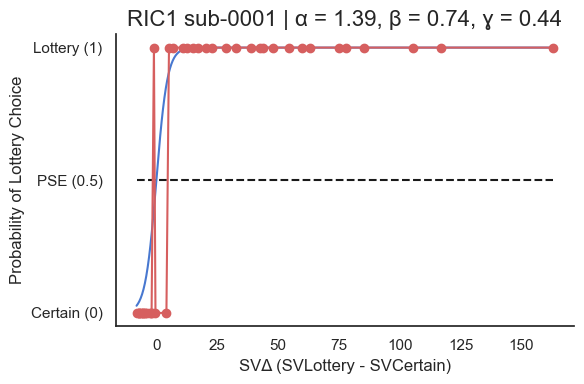

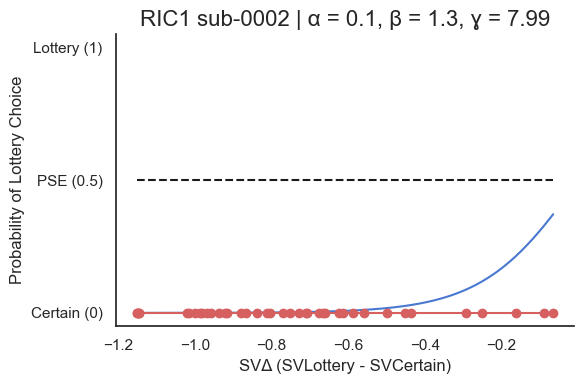

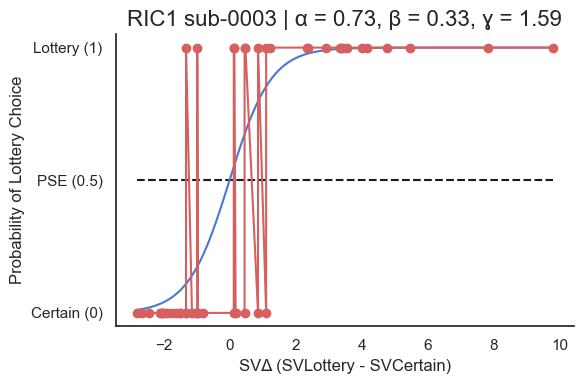

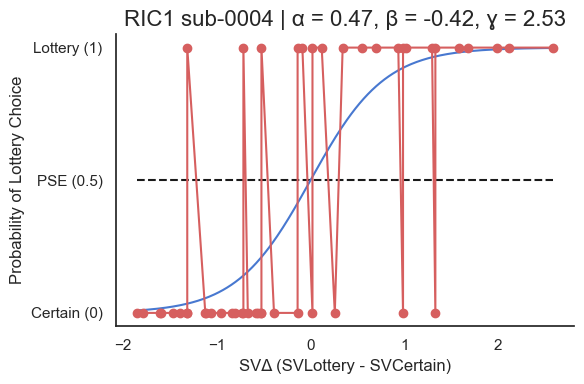

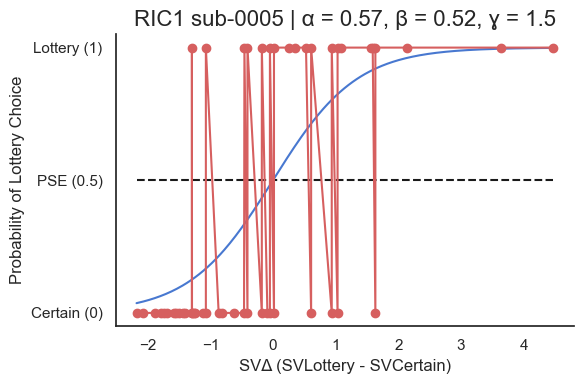

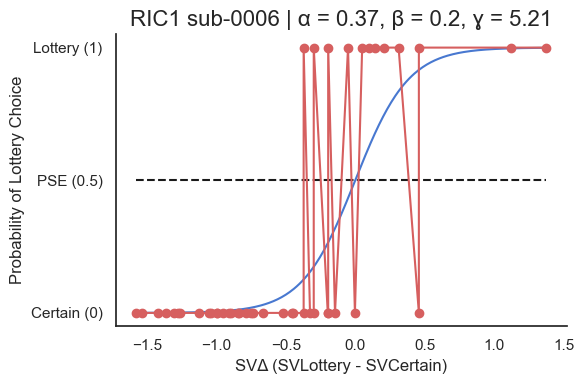

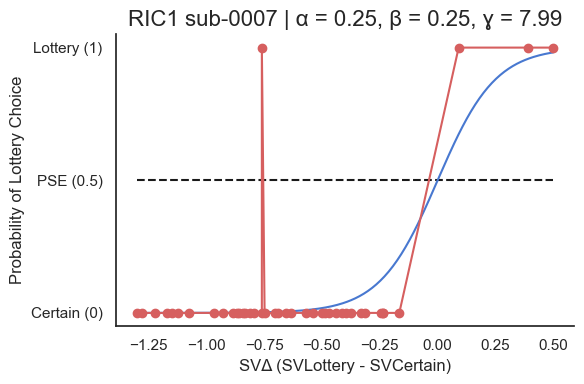

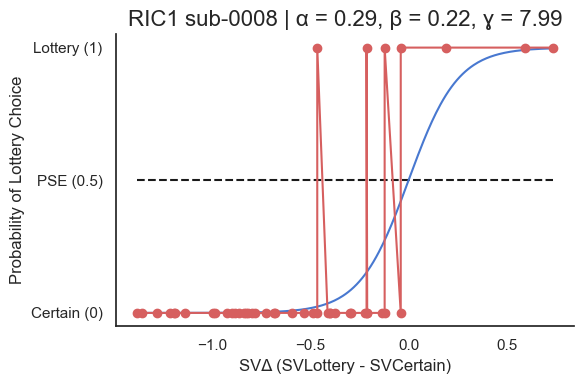

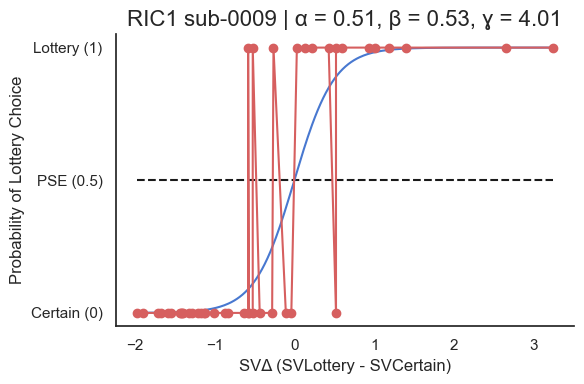

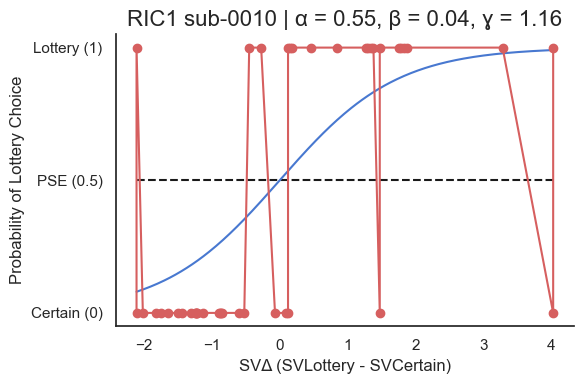

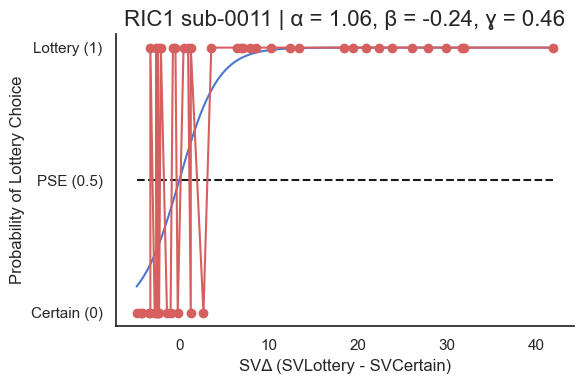

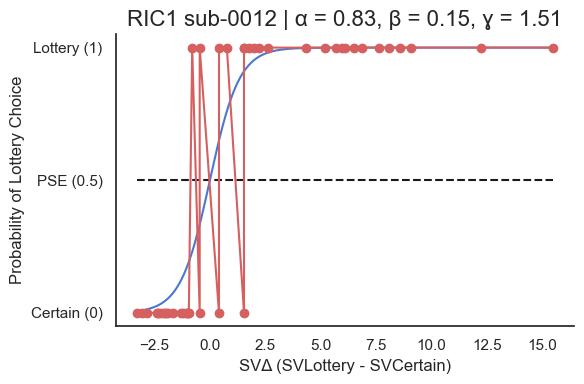

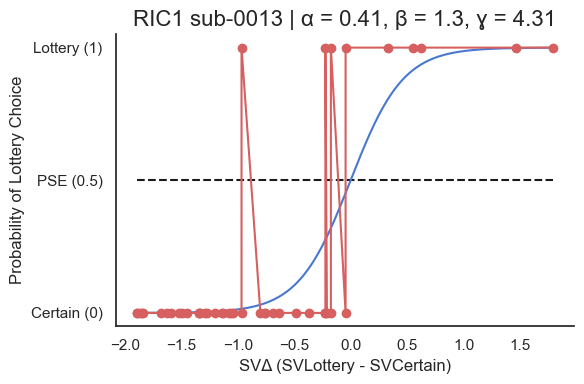

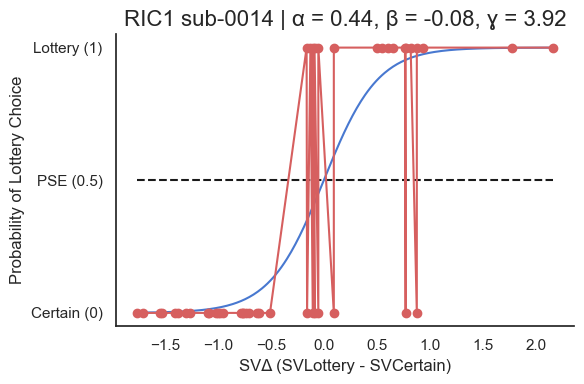

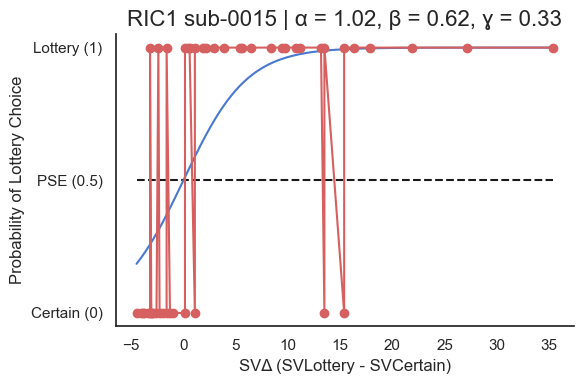

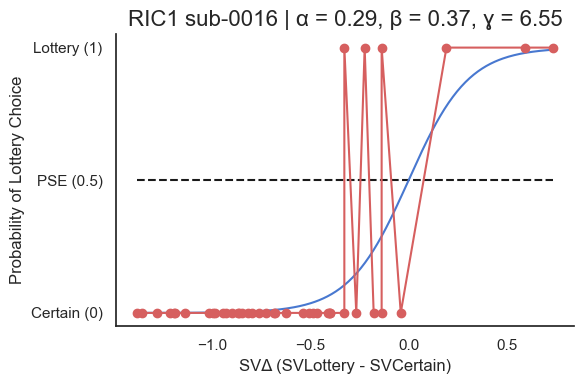

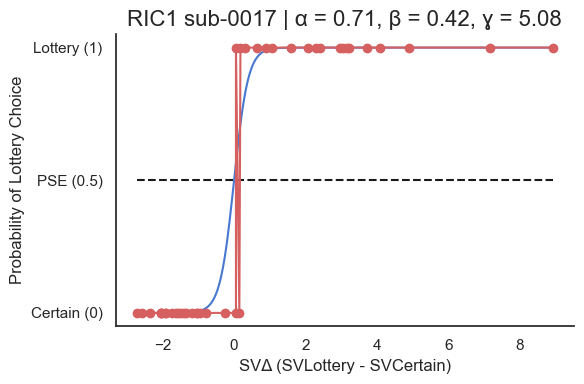

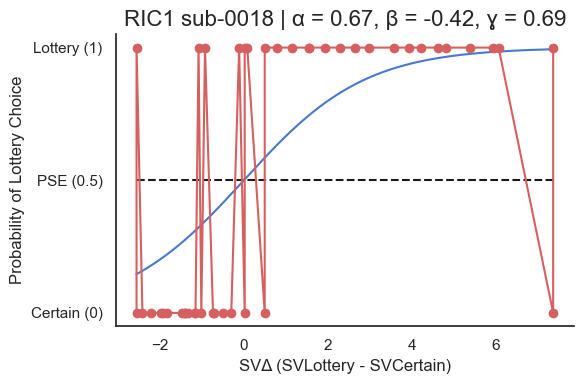

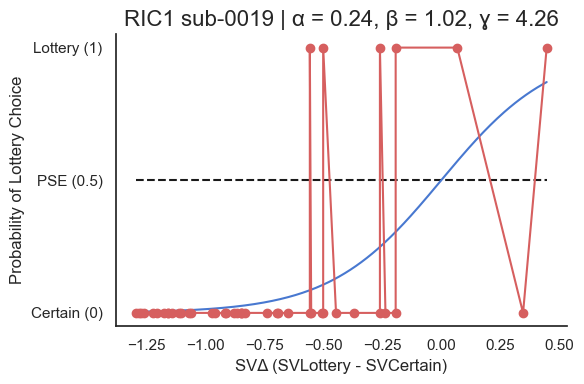

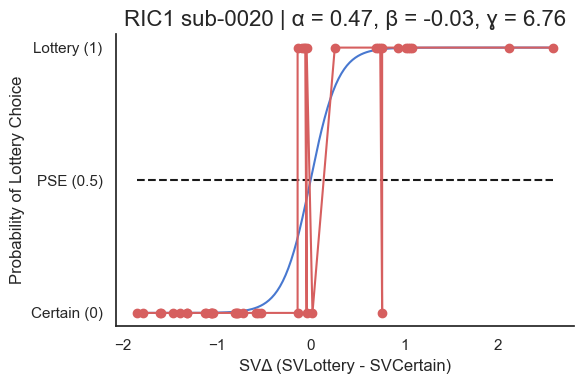

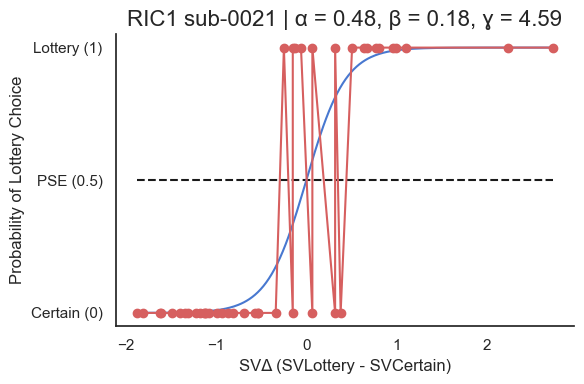

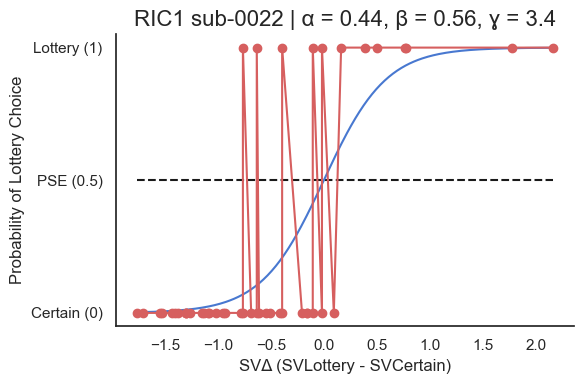

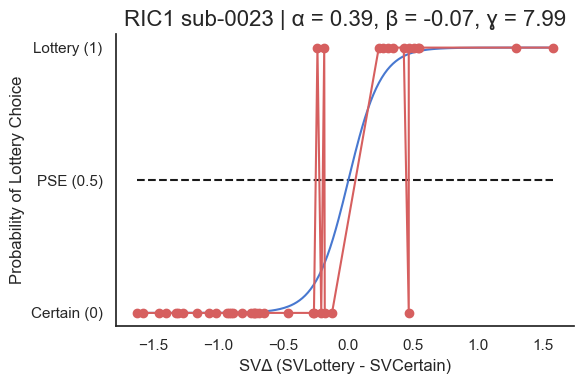

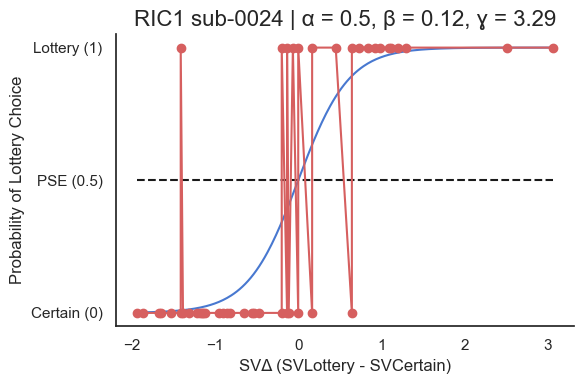

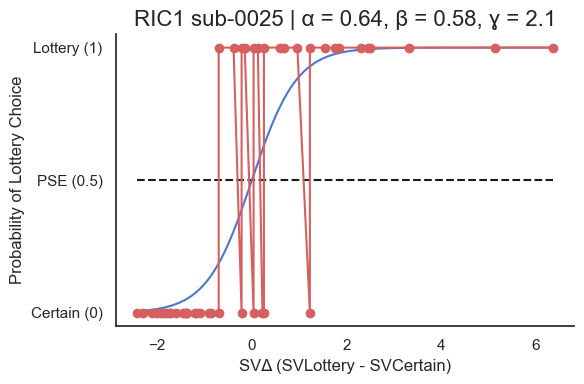

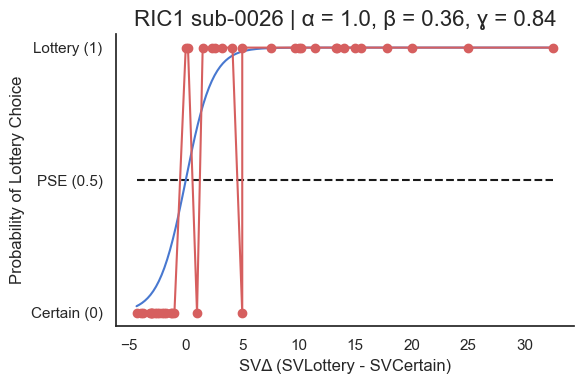

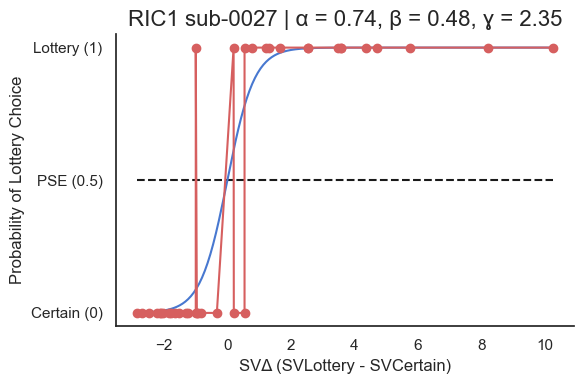

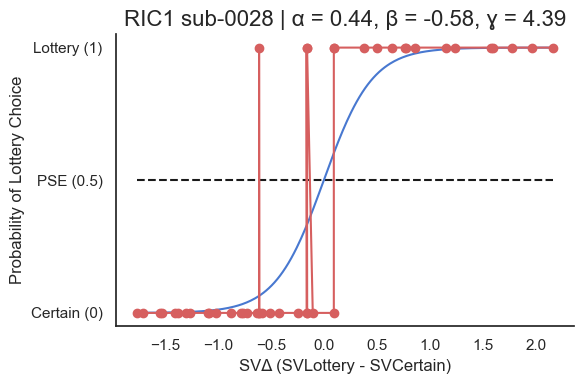

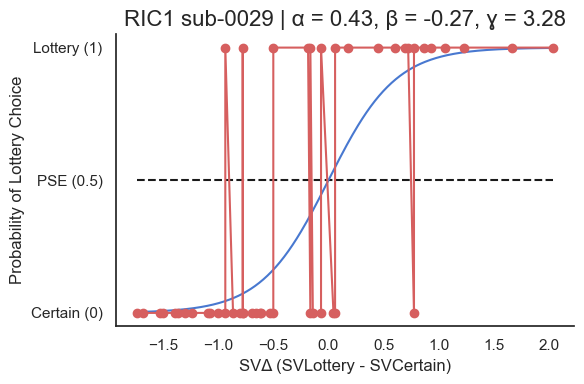

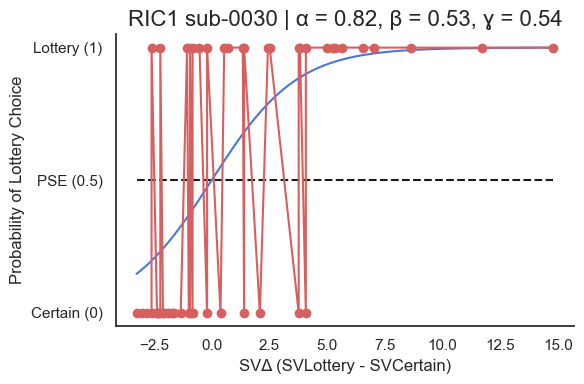

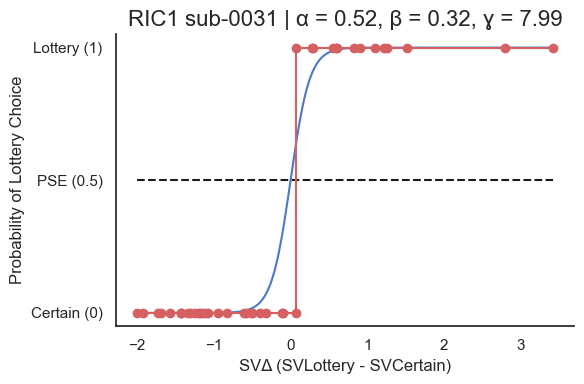

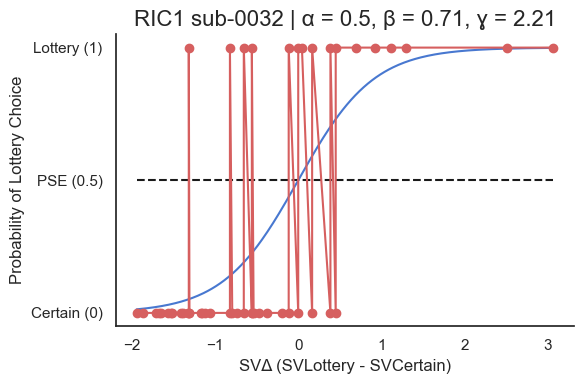

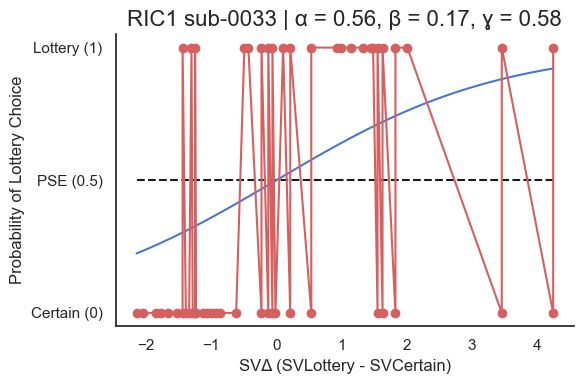

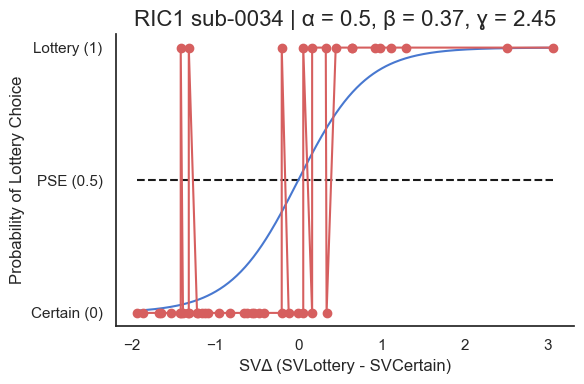

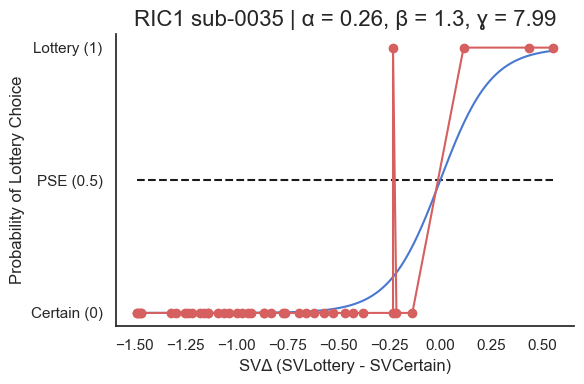

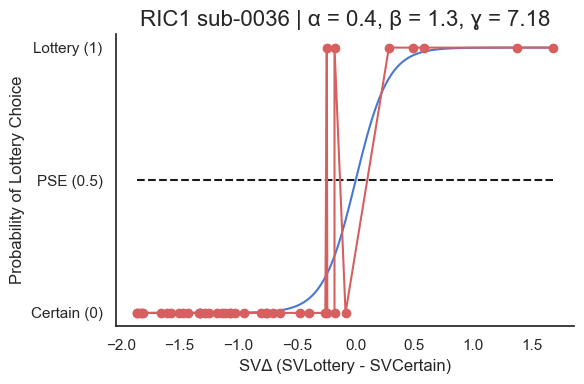

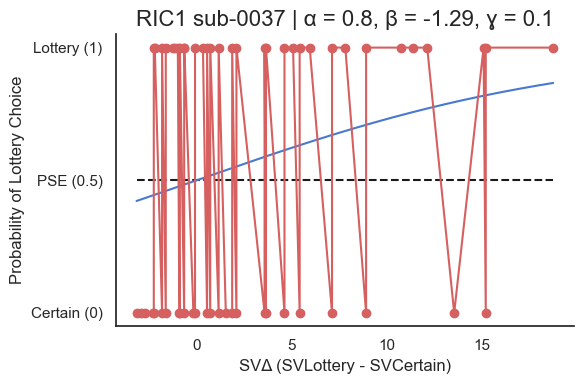

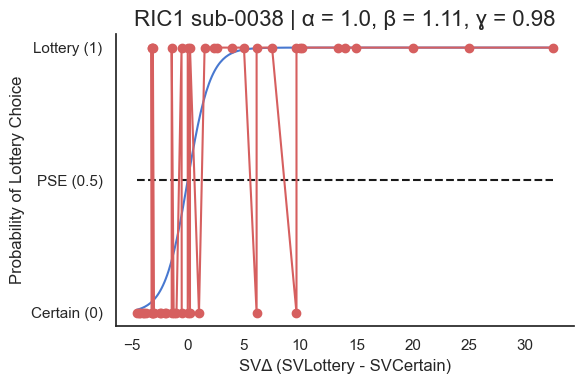

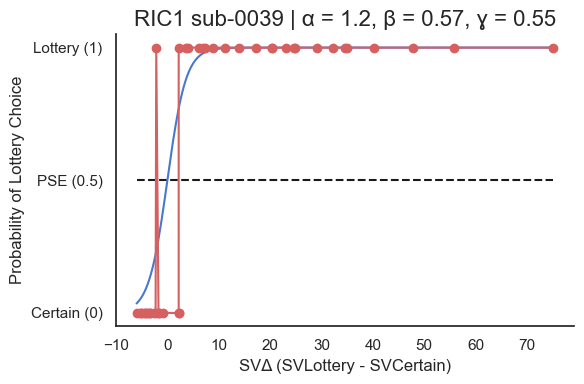

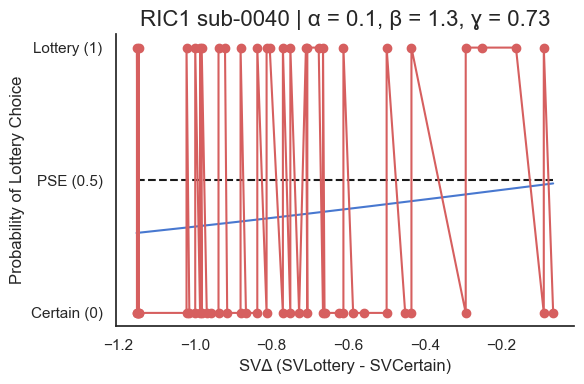

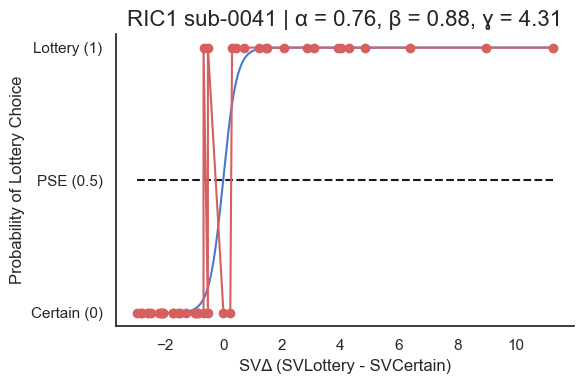

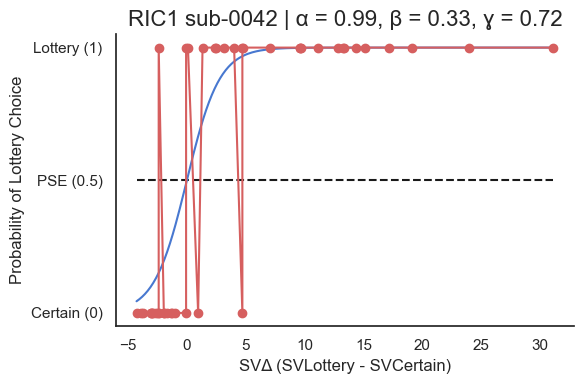

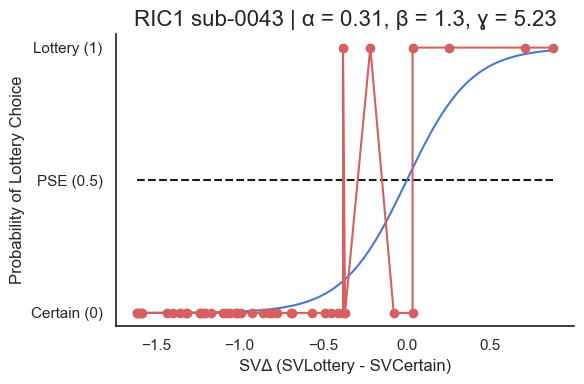

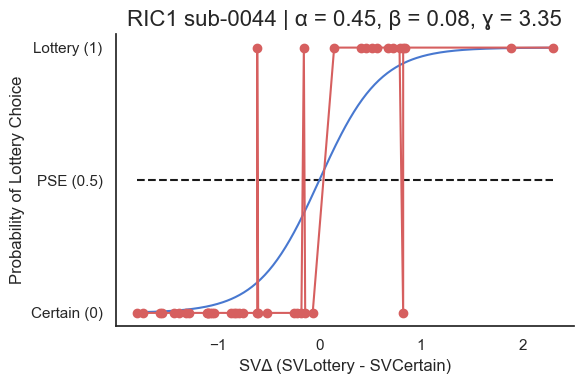

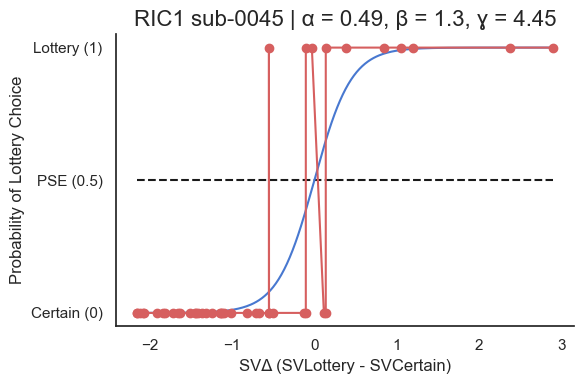

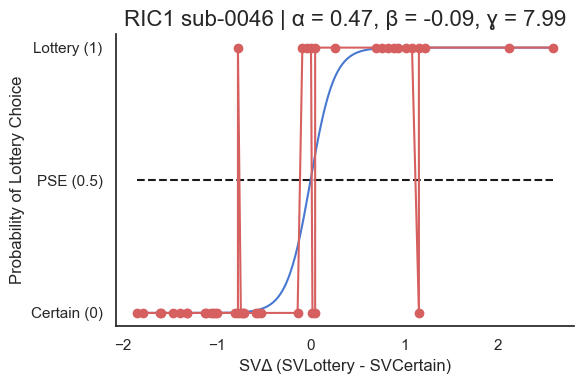

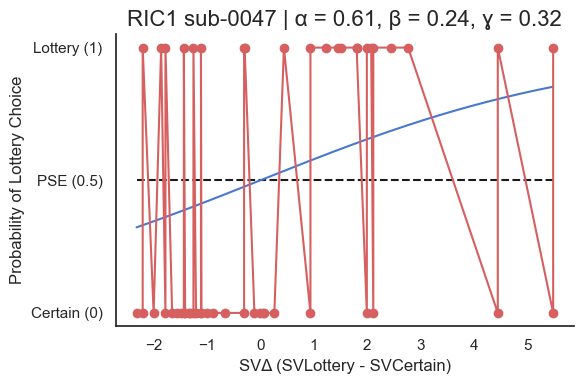

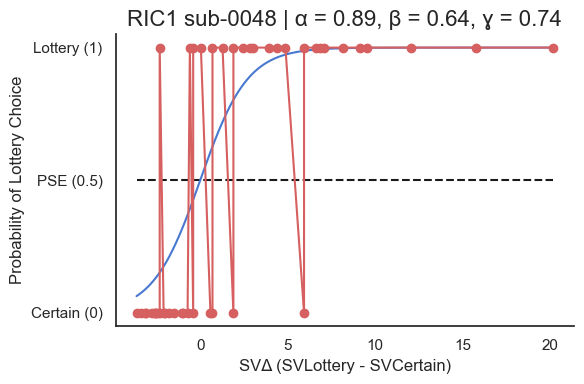

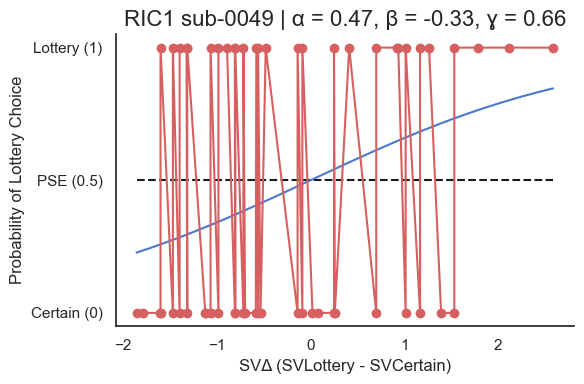

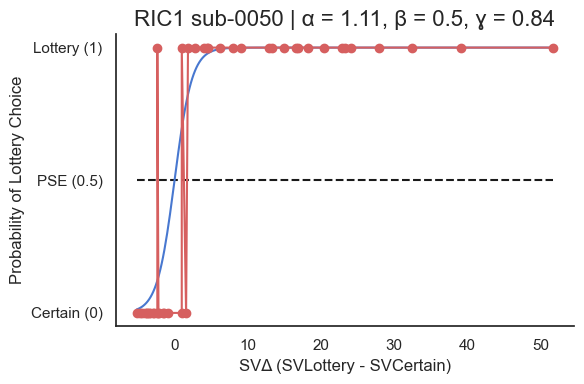

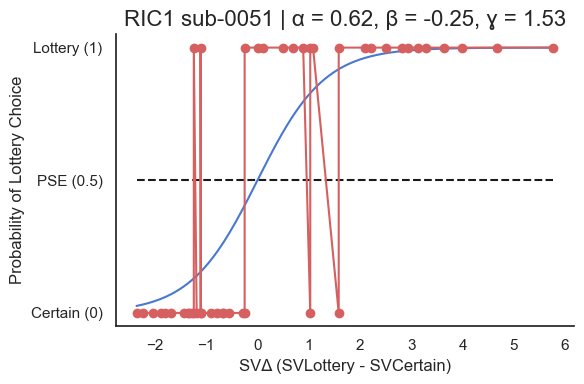

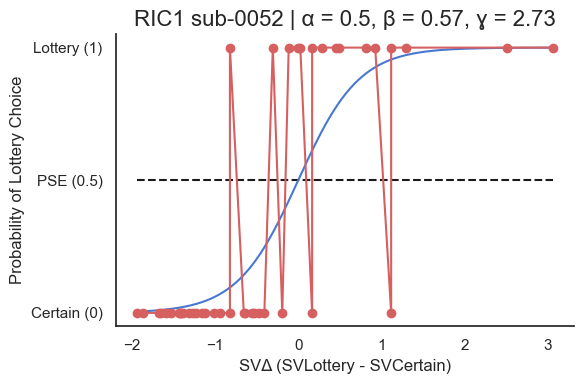

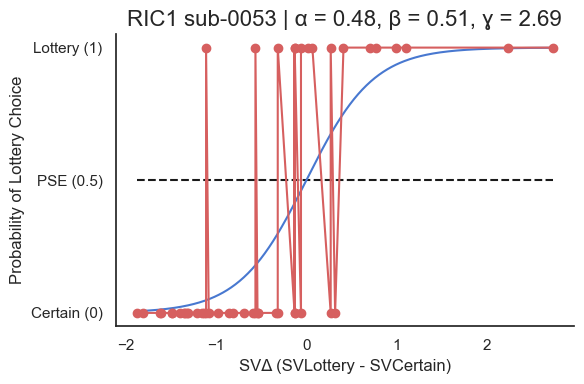

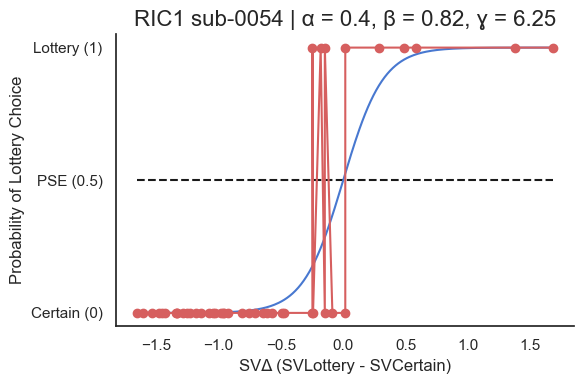

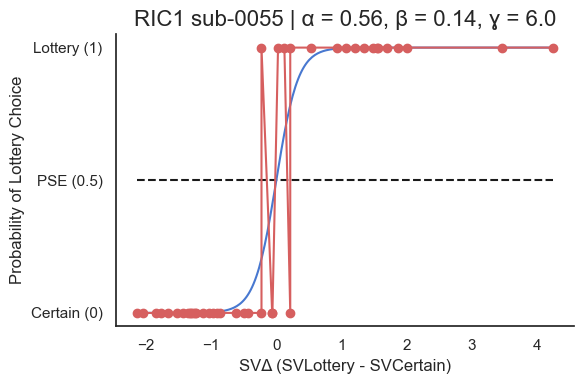

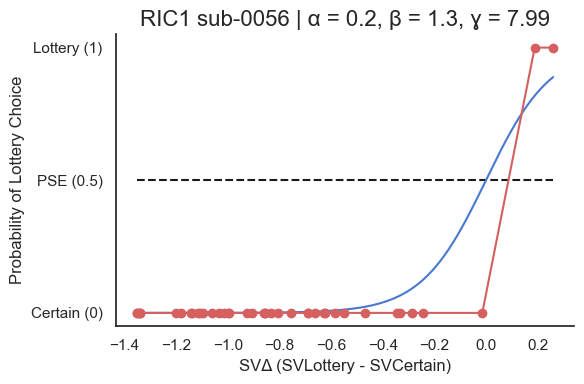

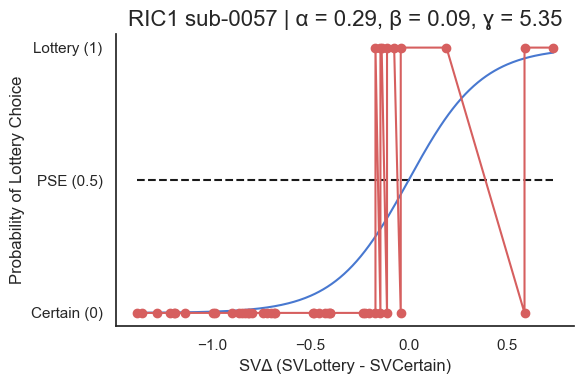

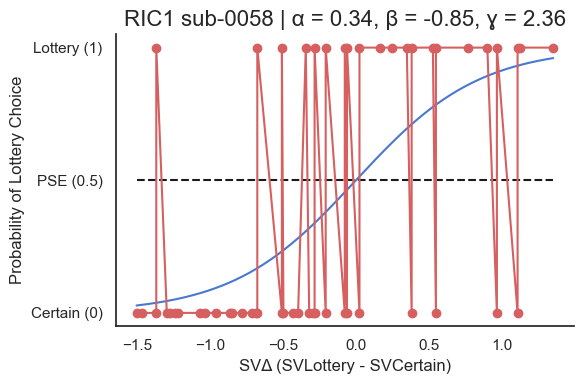

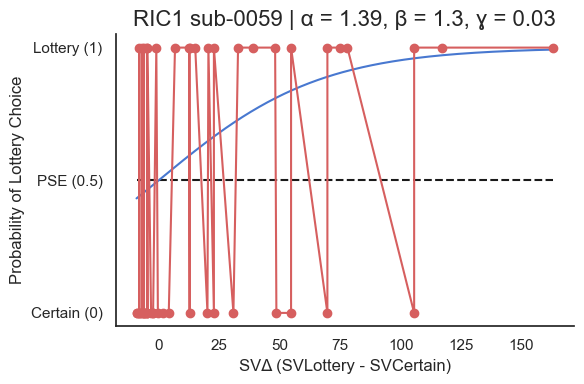

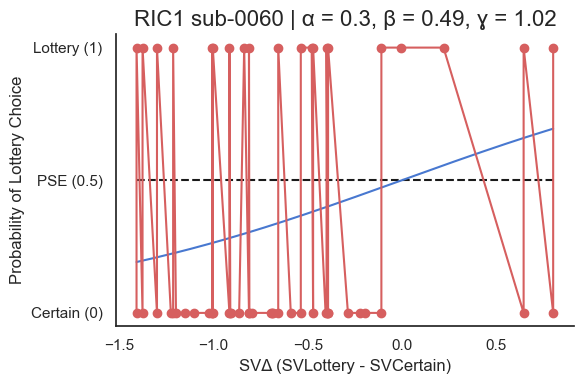

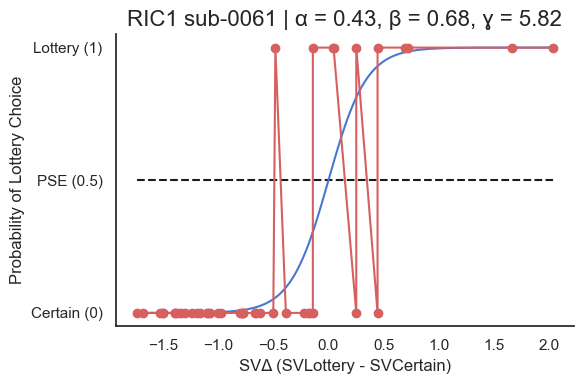

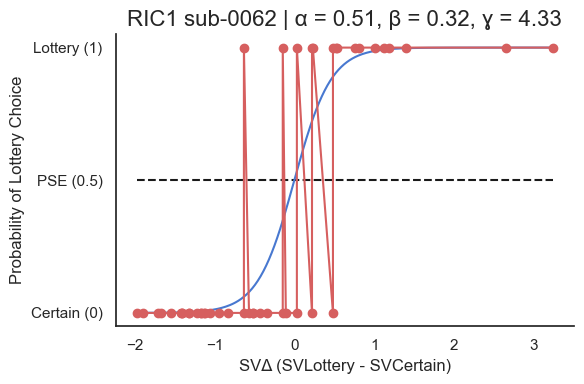

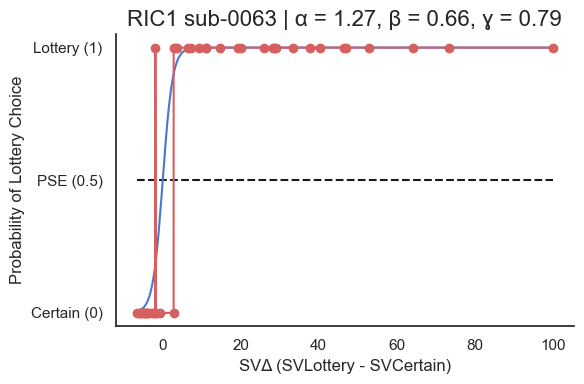

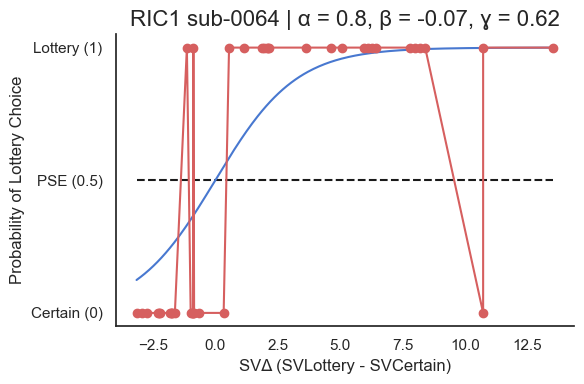

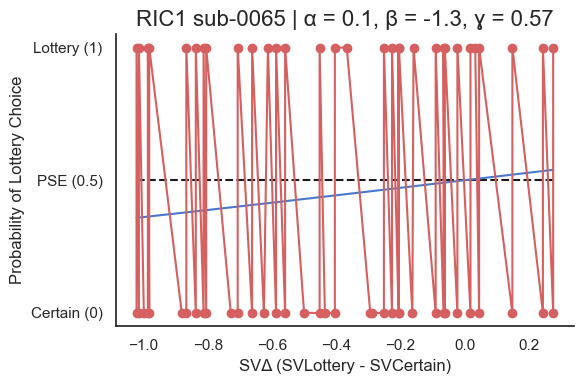

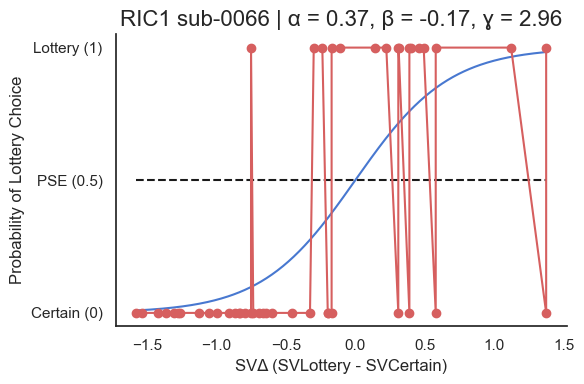

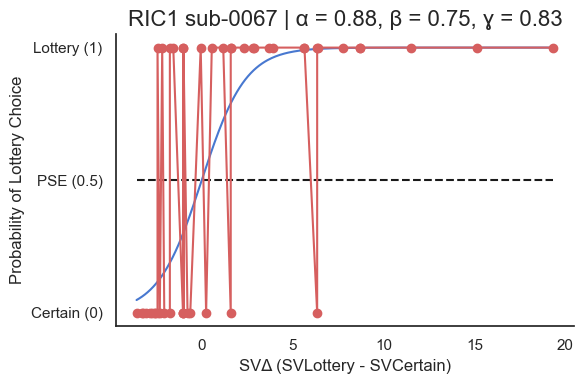

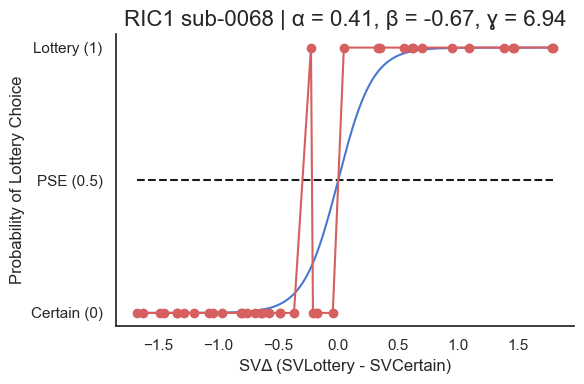

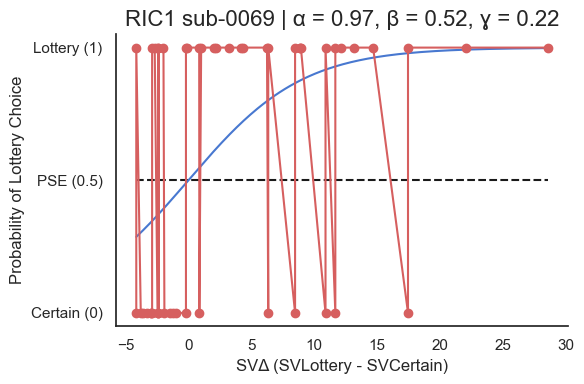

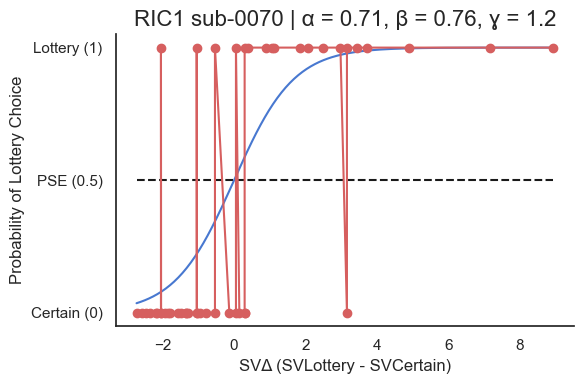

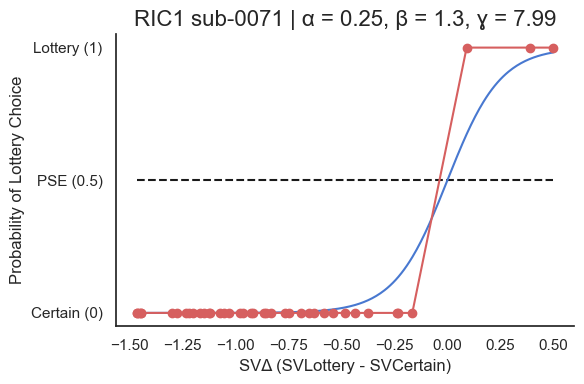

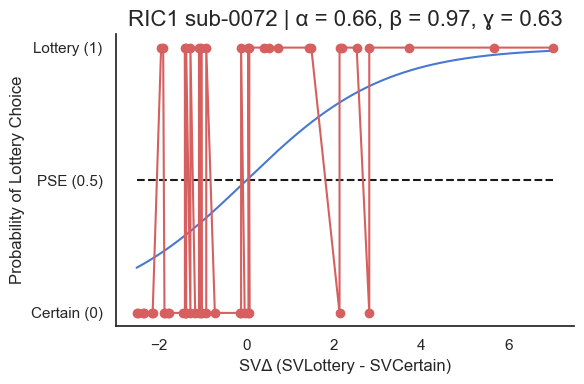

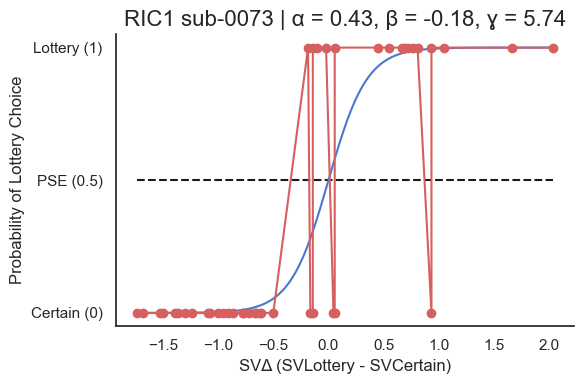

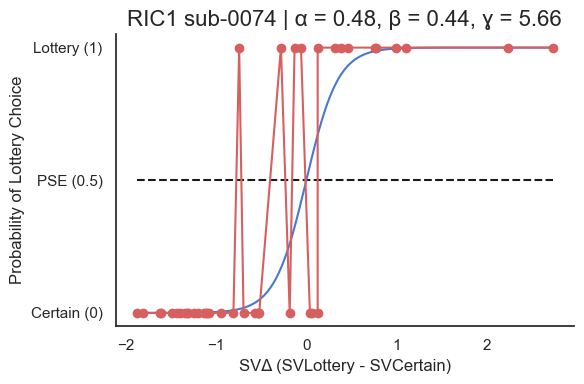

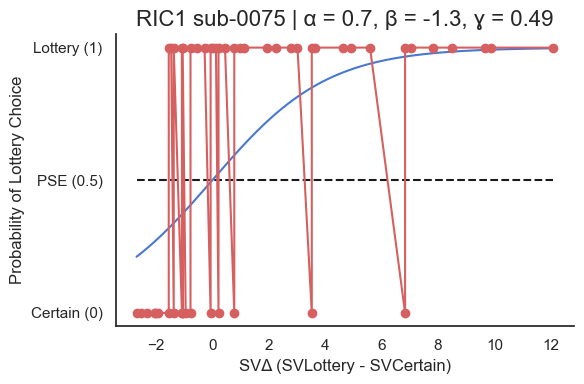

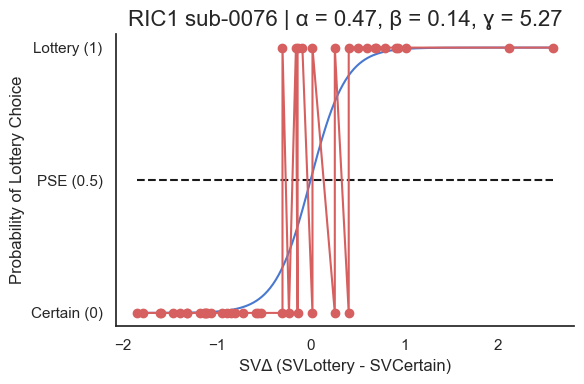

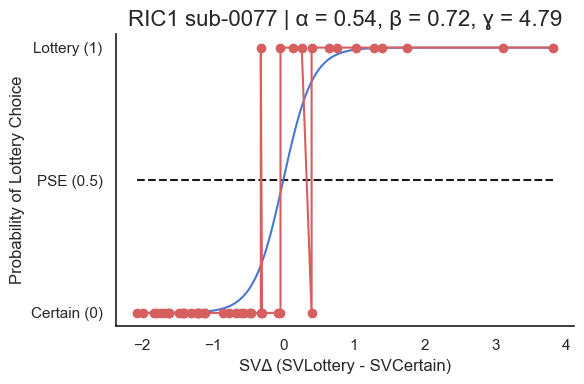

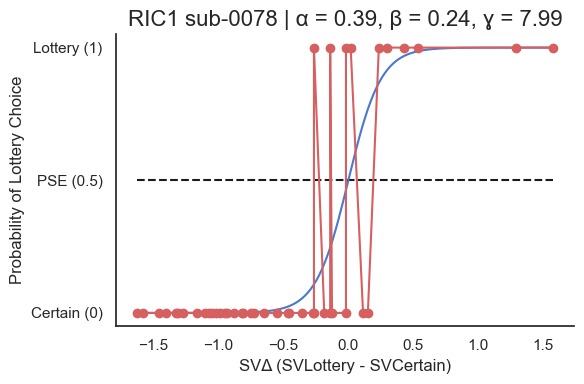

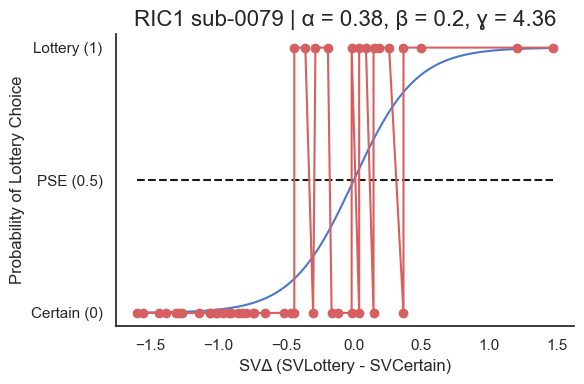

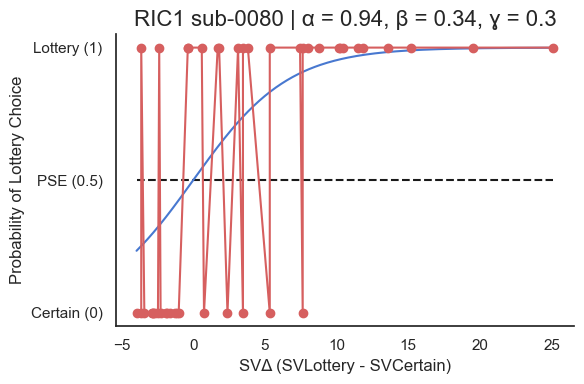

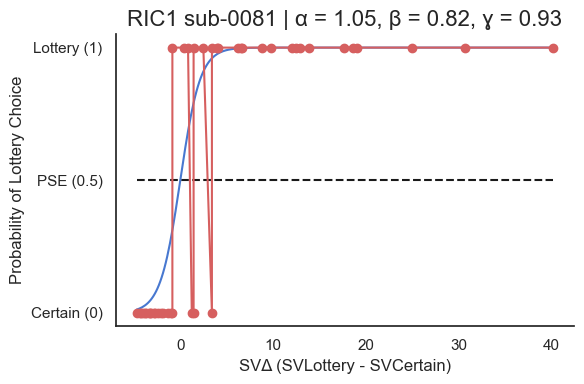

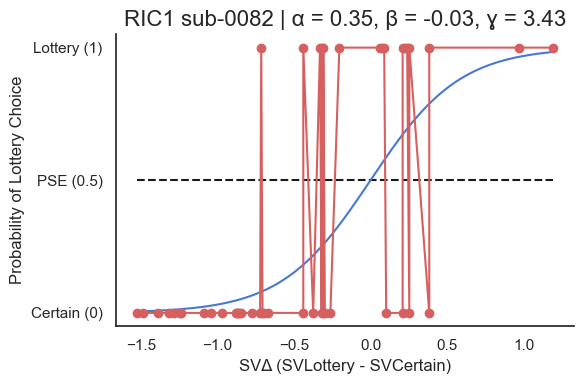

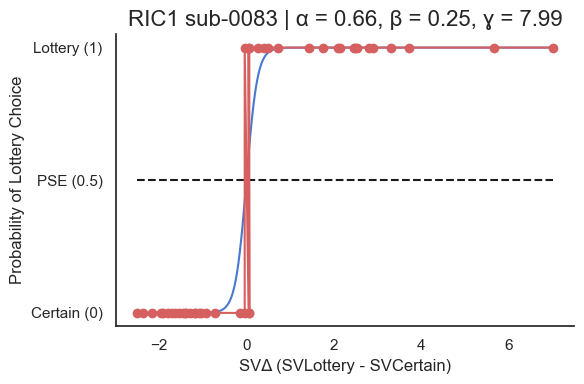

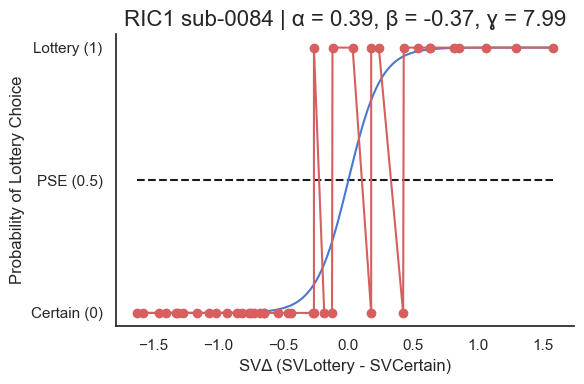

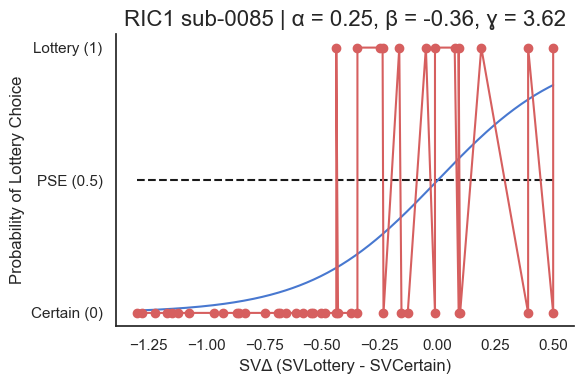

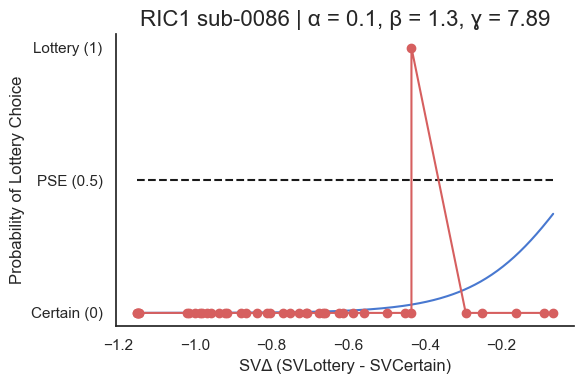

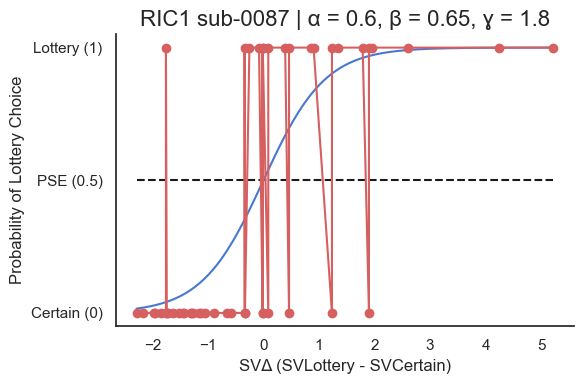

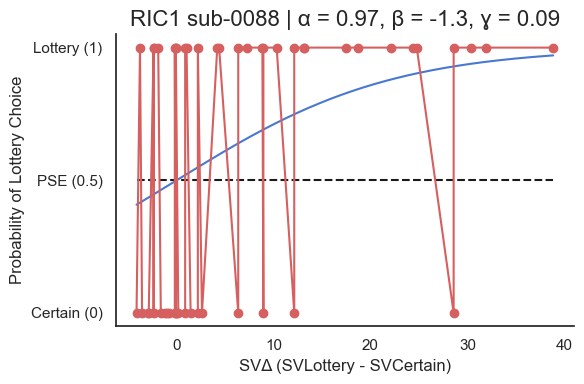

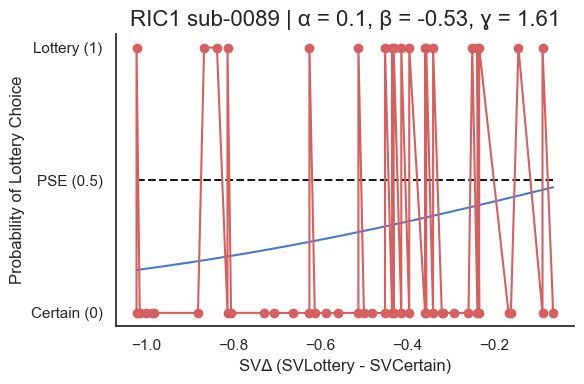

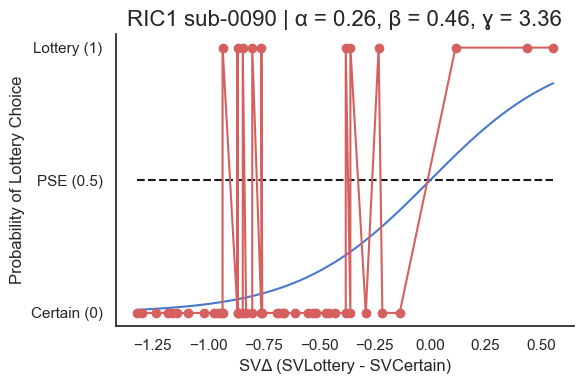

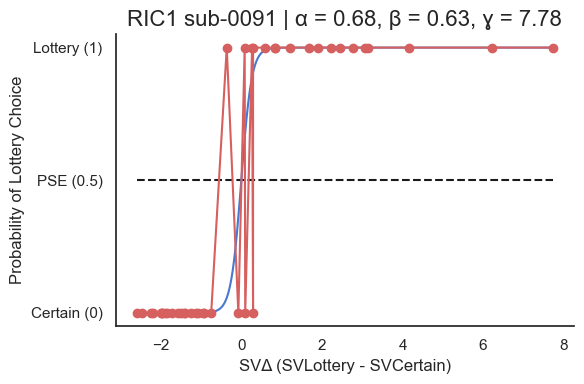

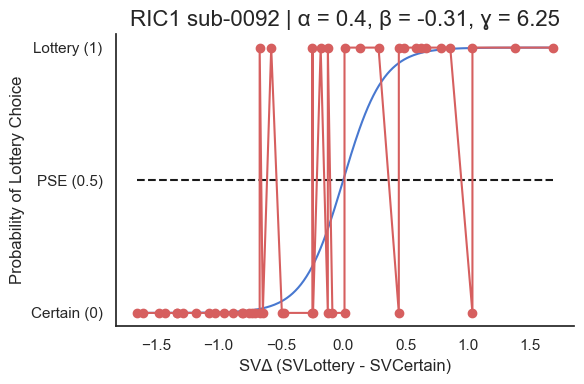

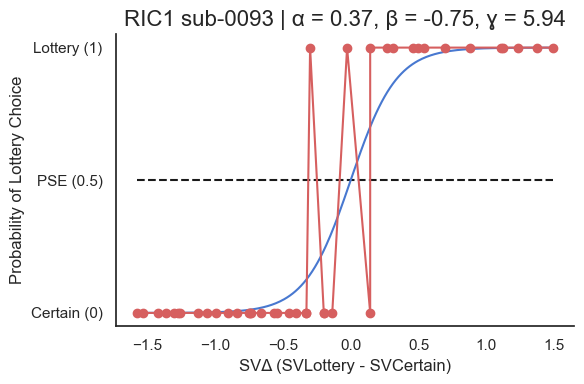

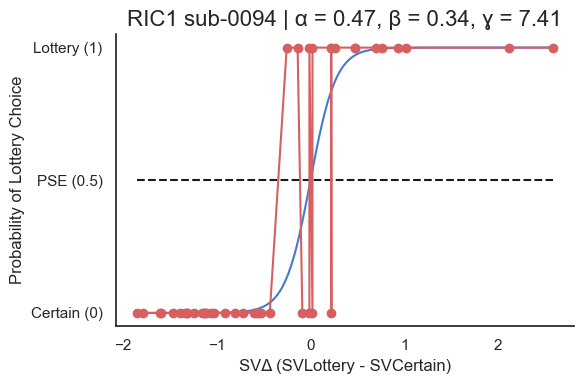

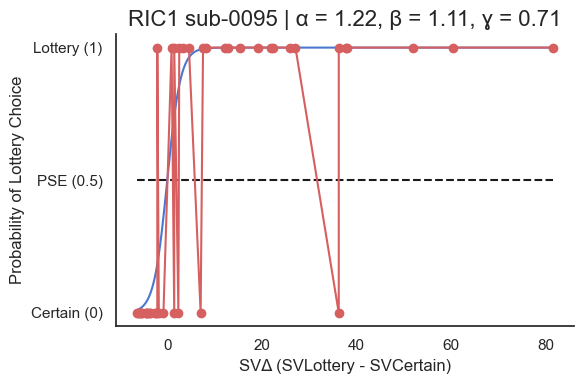

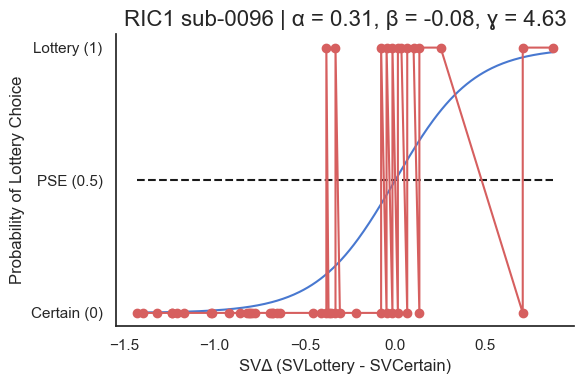

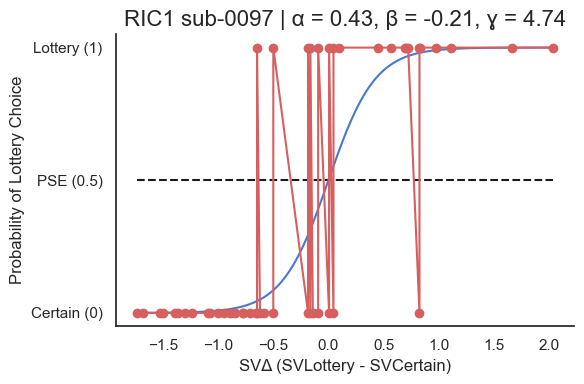

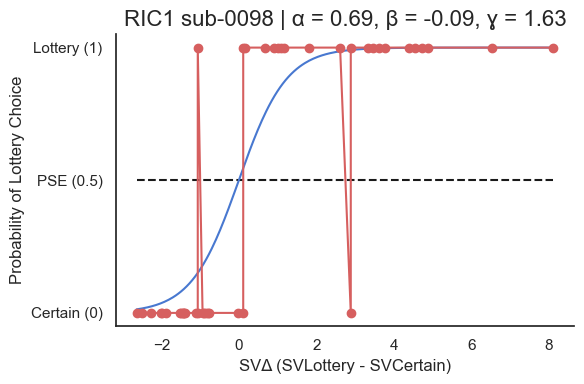

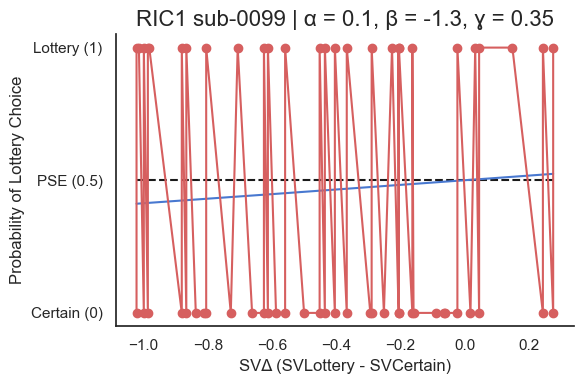

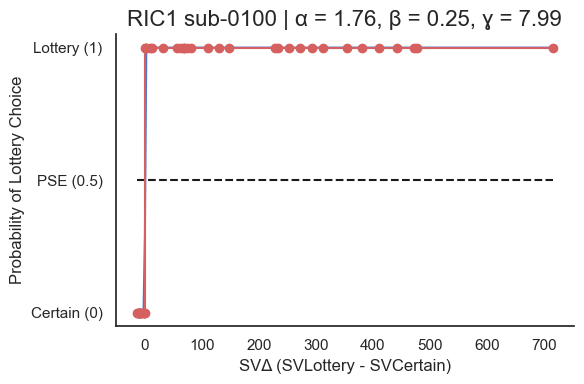

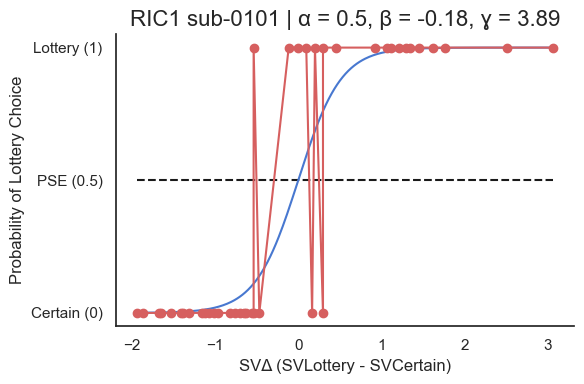

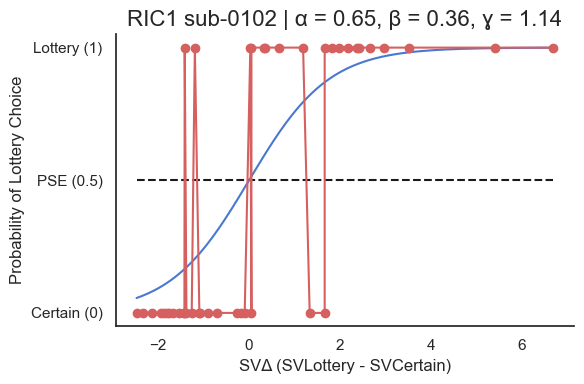

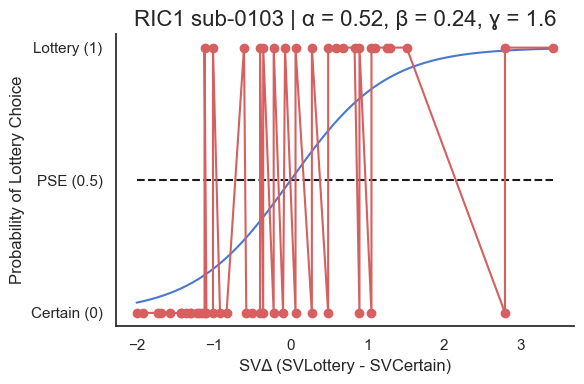

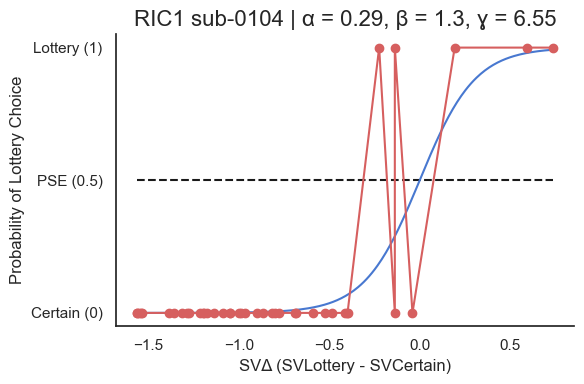

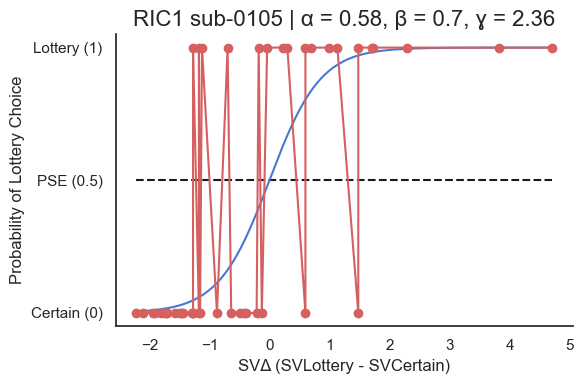

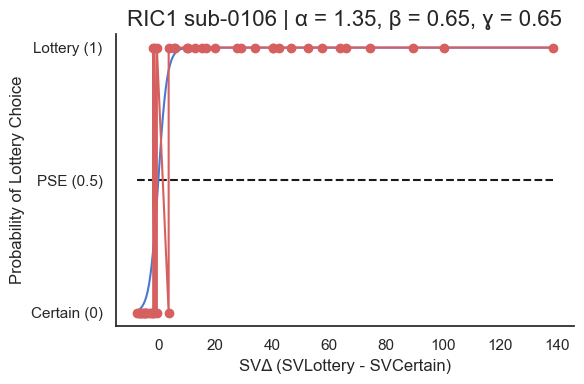

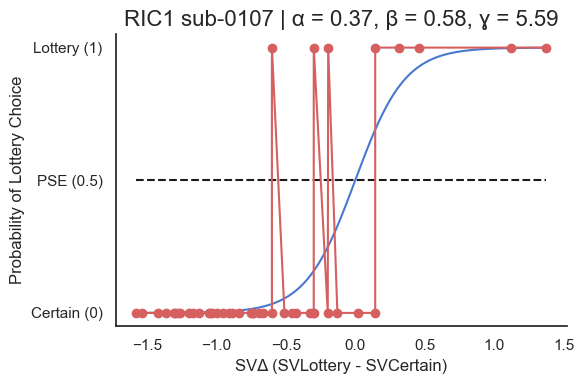

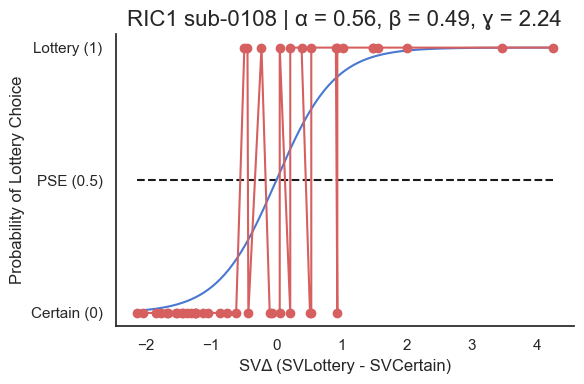

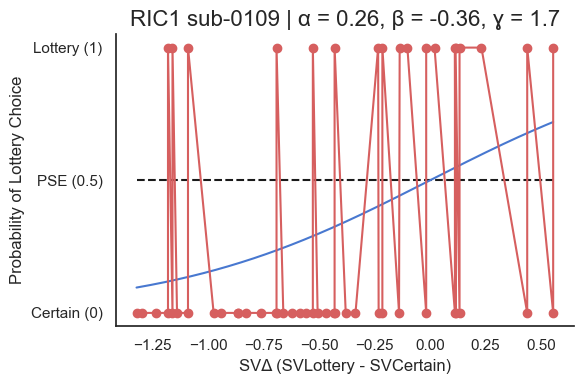

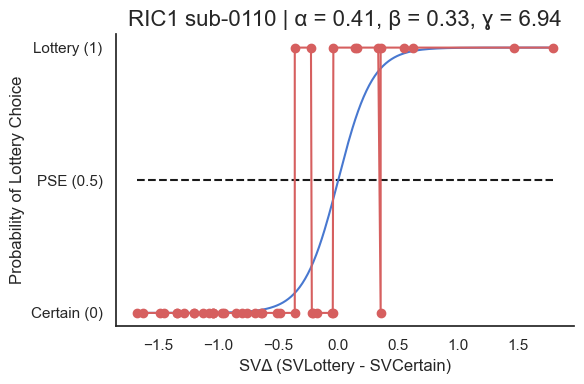

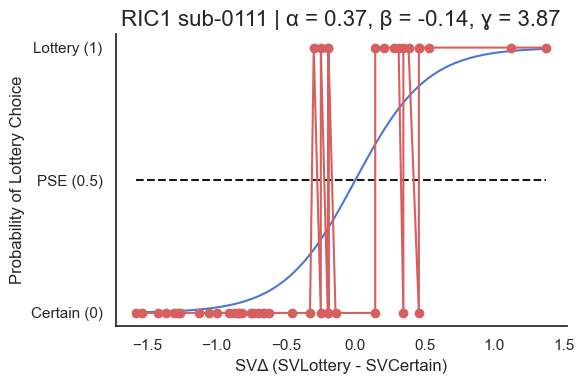

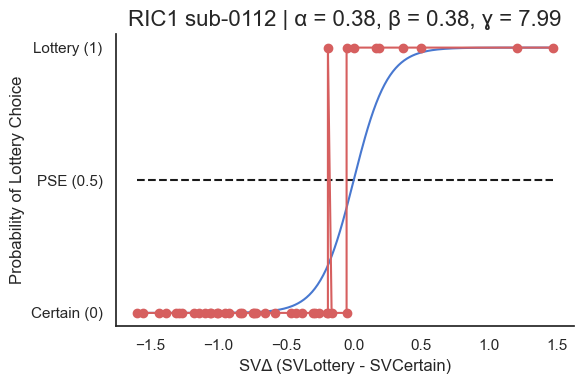

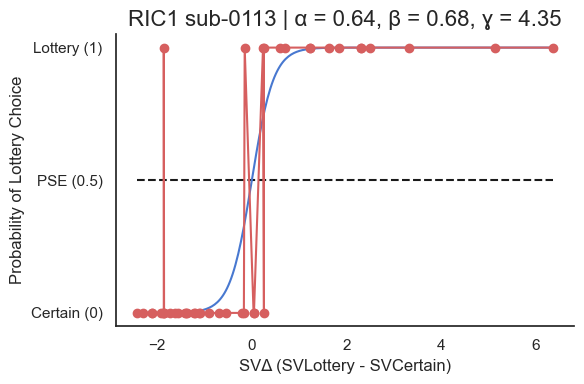

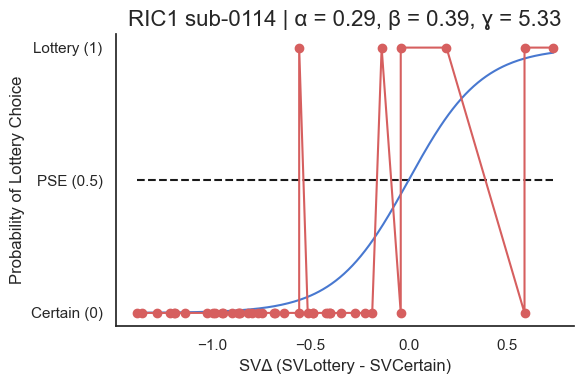

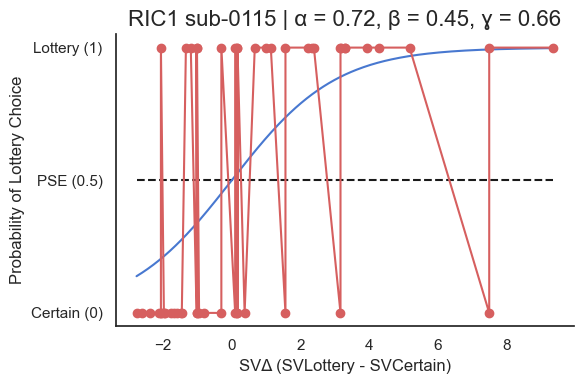

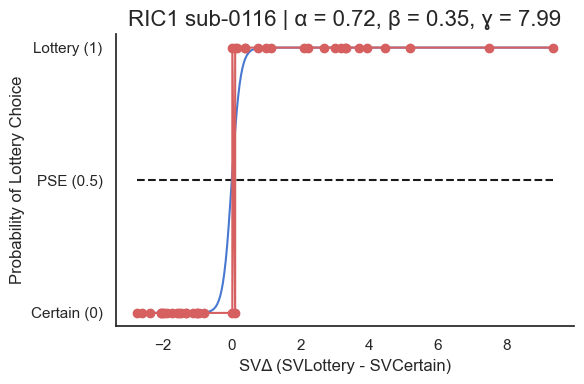

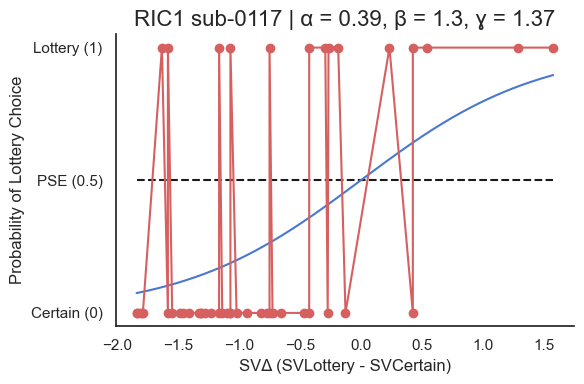

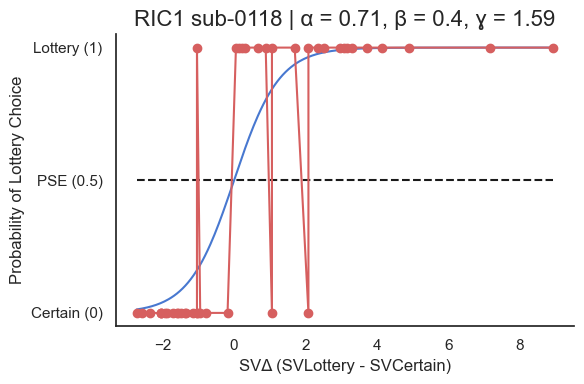

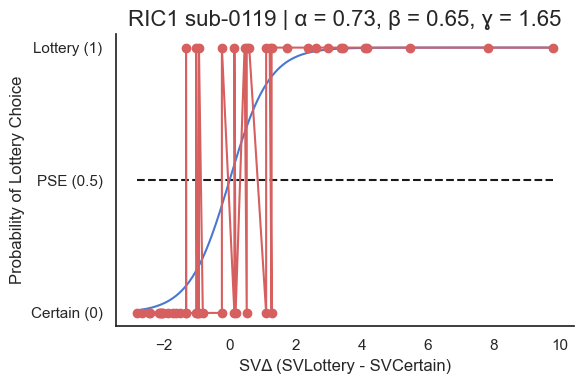

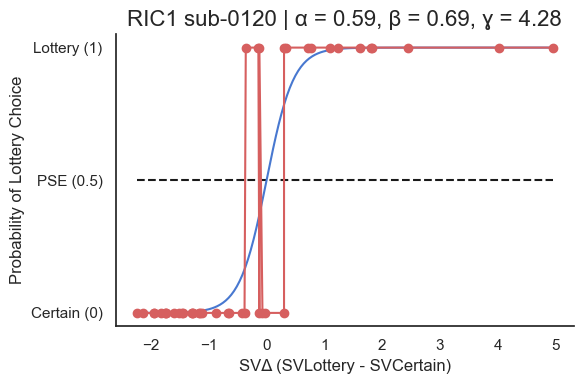

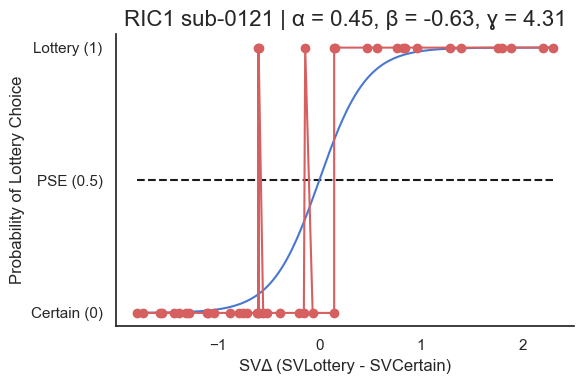

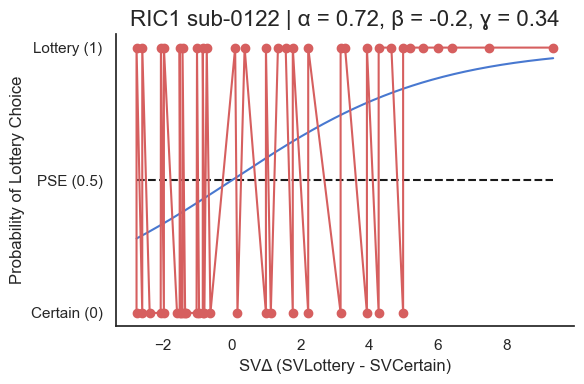

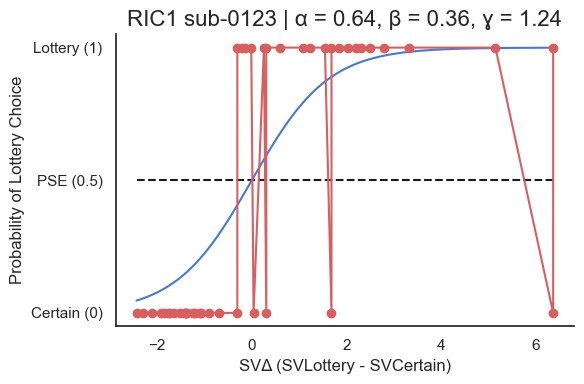

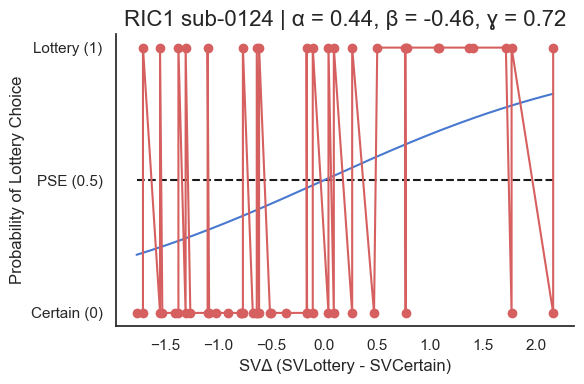

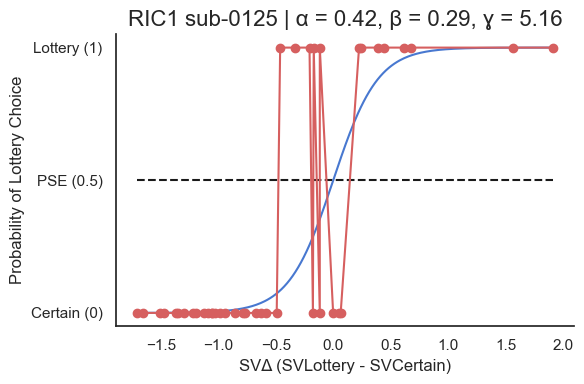

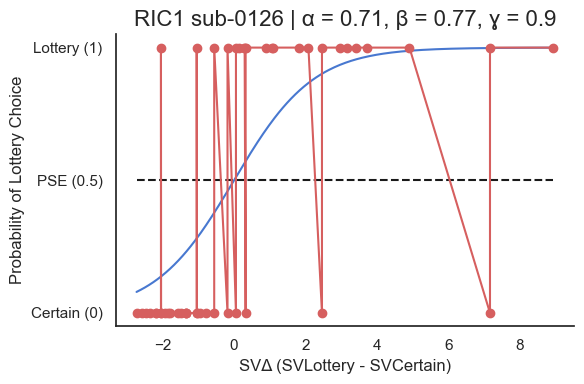

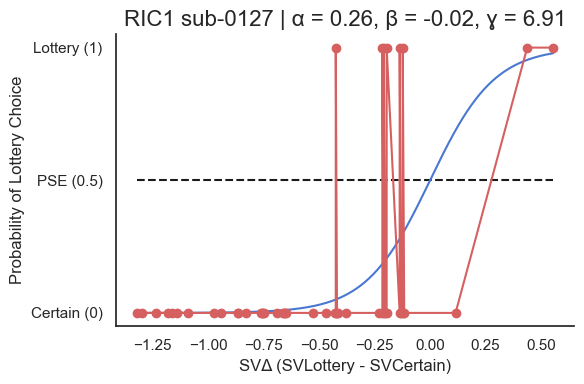

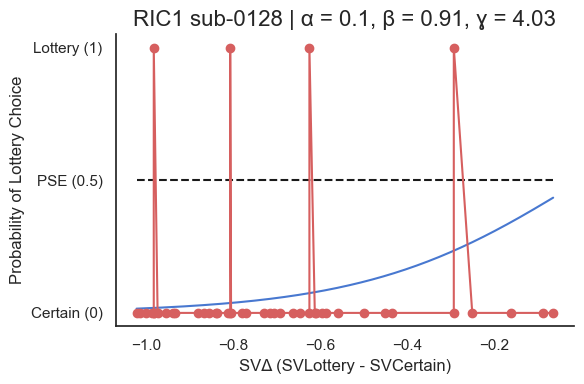

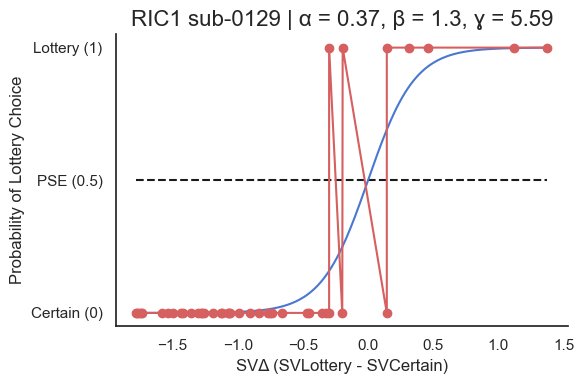

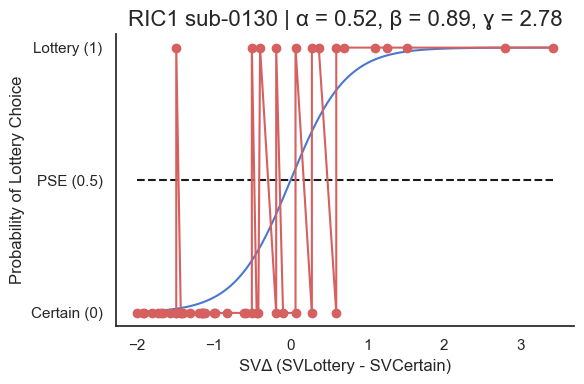

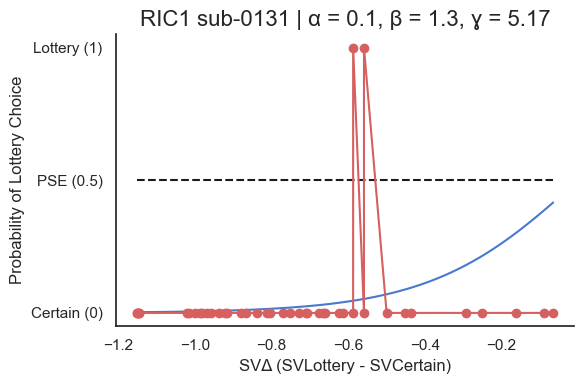

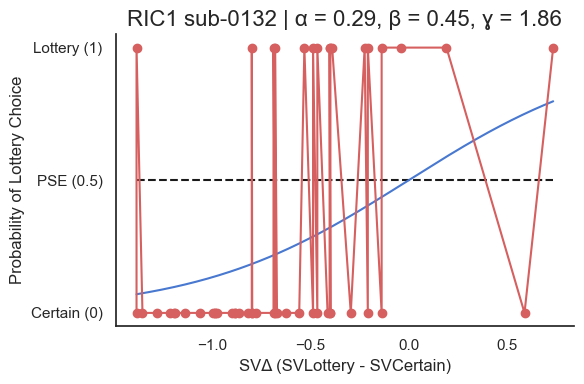

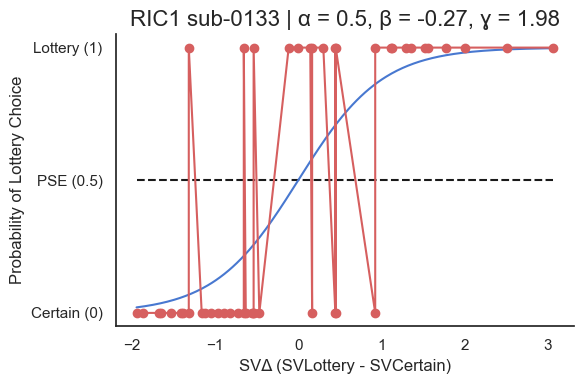

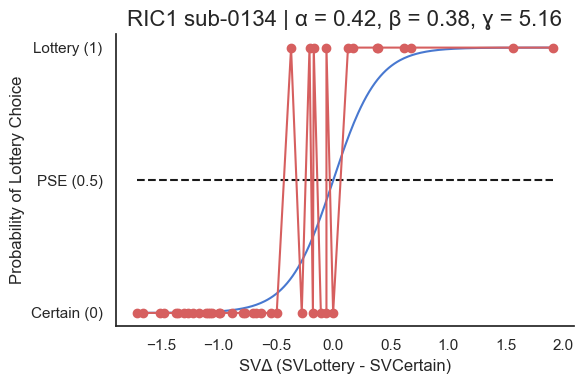

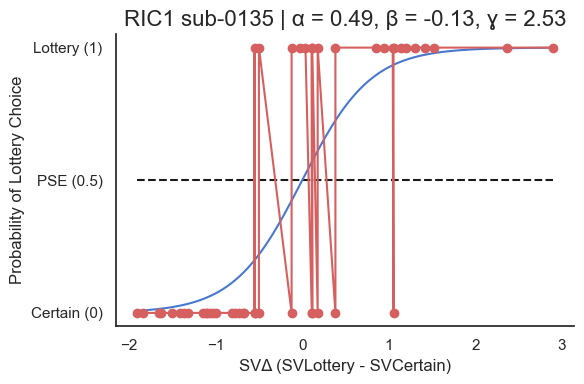

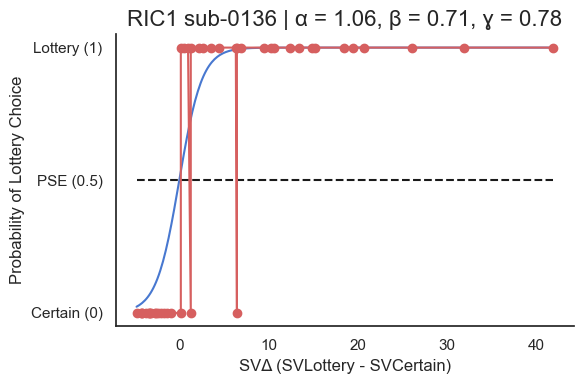

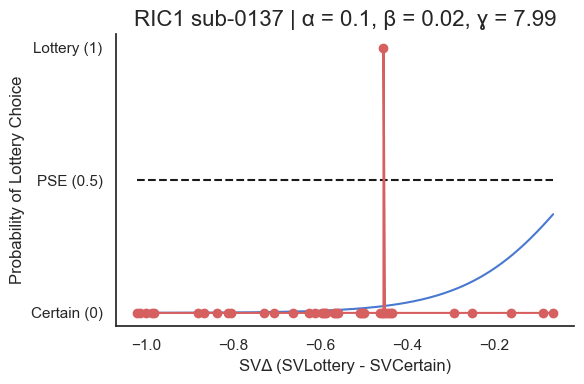

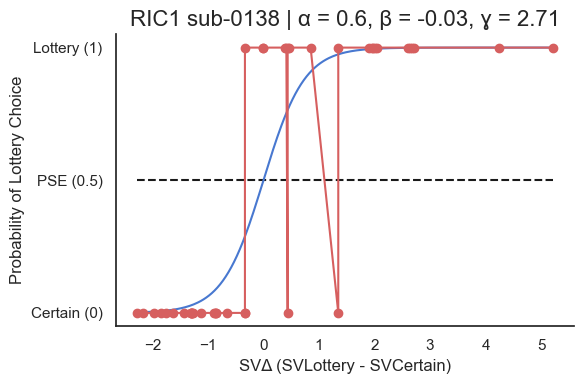

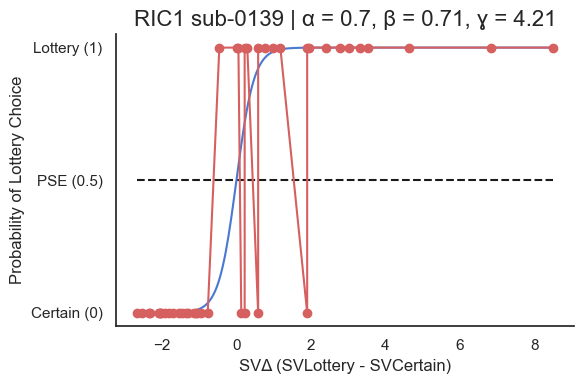

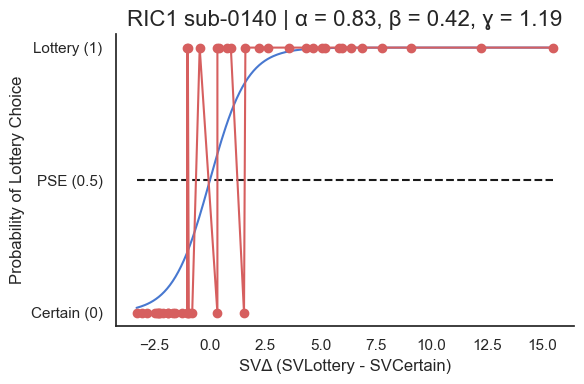

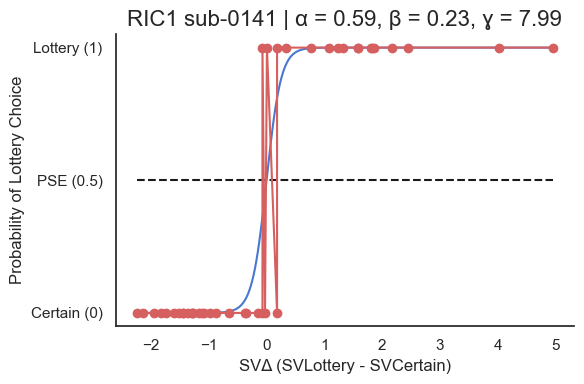

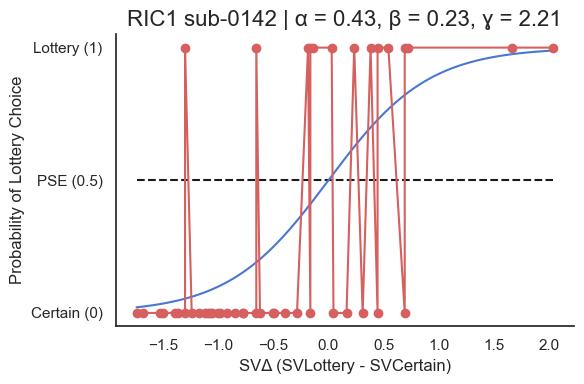

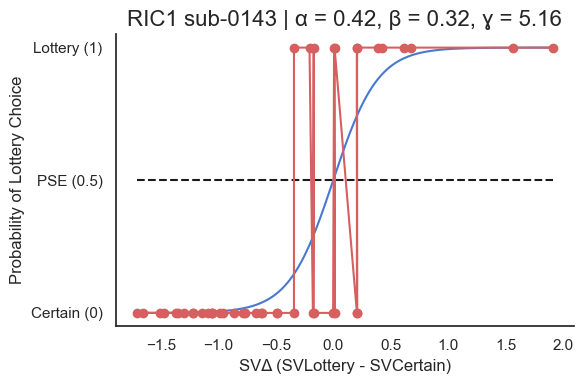

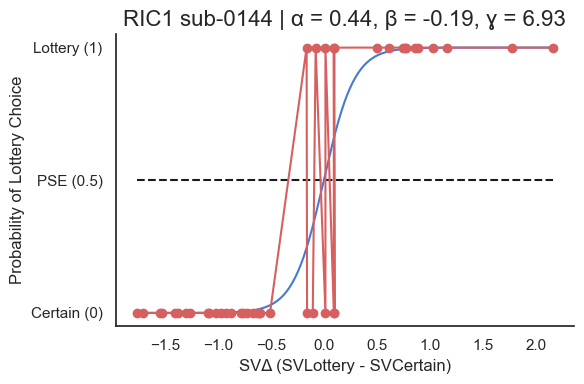

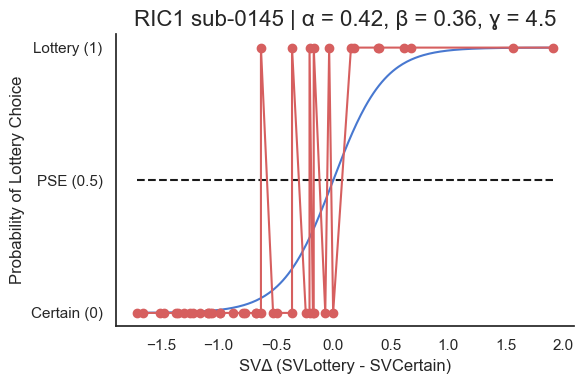

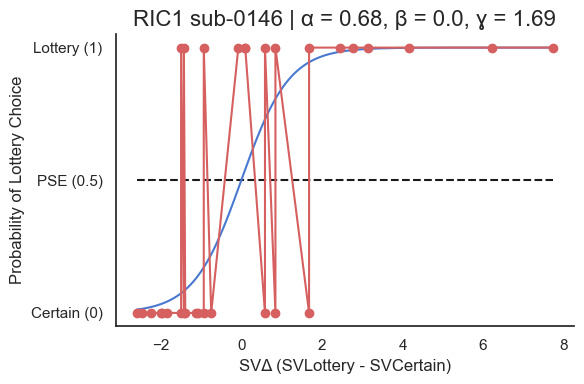

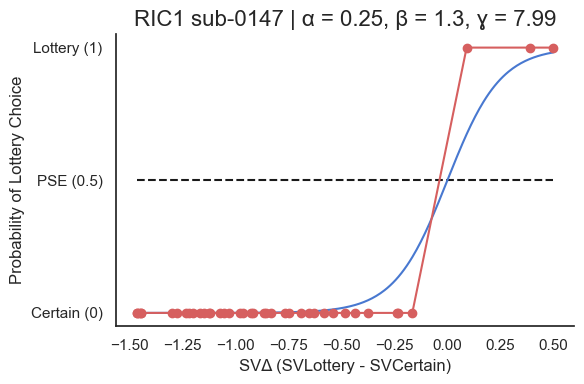

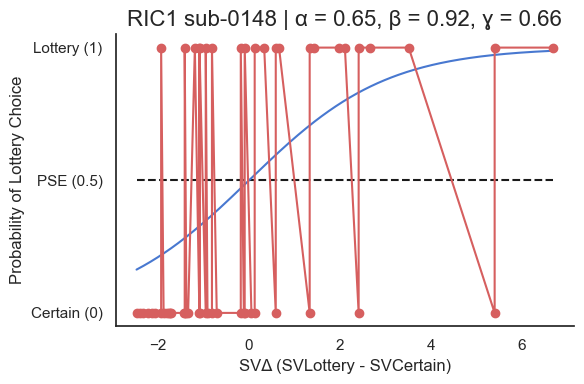

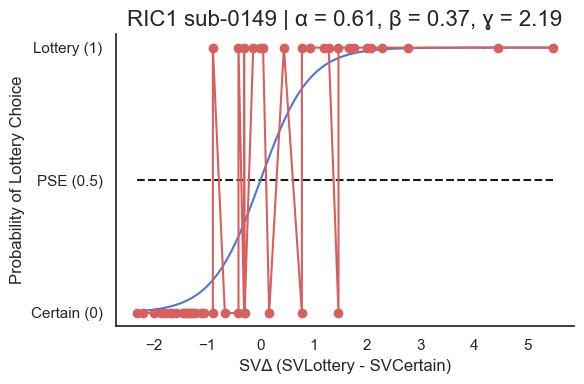

In [8]:
save_proj_dir = os.path.join(base_proj_dir, "derivatives/RIC1/parameter_estimation/crdm/softmax") ## output directory

subs = [] ## list to store subject IDs
descriptives = {"resp_rate":[], "prop_lott_risk":[], "prop_lott_amb":[], "prop_lott_all":[],
                "conf1_ct":[], "conf2_ct":[], "conf3_ct":[], "conf4_ct":[], "conf_mean":[],
                "conf_median":[], "at_bound":[]}
df_participants = pd.DataFrame(columns = ["SubID", "Domain", ## Ss parameters dataframe
                                            "Alpha", "Beta", "Gamma", 
                                            "MaxLL", "R2", "AIC", "AIC0"]) 

files = sorted(glob(os.path.join(data_dir, "23_IDM_*.csv"))) ## grab all participant datafiles
for curr_file in files: ## iterate through globbed files and save subject ID to a list
    sub_id = os.path.basename(curr_file)[7:11] ## grab first 5 indices of filename string
    if not sub_id in subs: ## check if already in list
        subs.append(sub_id) ## if not, append new Ss ID to list

for idx, sub in enumerate(subs): ## iterate through Ss ID list
    sub_files = sorted(glob(os.path.join(data_dir, "23_IDM_{0}.csv".format(sub)))) ## grab all IDM task csvs
    sub_cols = ["domain", "prob", "amb", "sure_amt", "lott_amt", "choice"] ## trial variables
    sub_df = pd.DataFrame(columns = sub_cols) ## subject-specific dataframe w/ preset columns
    raw_df = pd.read_csv(sub_files[0]) ## open current data file
    df = raw_df.loc[(raw_df["crdm_trial_type"] == "task") & (raw_df["crdm_choice"].notnull())] ## only CRDM task trials w/ responses
    sub_df["domain"] = df["crdm_domain"] ## trial type (gain/loss)
    sub_df["prob"] = df["crdm_lott_p"] ## trial probability
    sub_df["amb"] = df["crdm_amb_lev"] ## trial ambiguity
    sub_df["sure_amt"] = df["crdm_sure_amt"] ## trial certain amount
    sub_df["lott_amt"] = df["crdm_lott_top"] + df["crdm_lott_bot"] ## trial lottery amount
    sub_df["choice"] = df["crdm_choice"] ## trial choice (-1 = nonresponse, 0 = certain, 1 = lottery)
    sub_gains = sub_df.loc[(sub_df["domain"] == "gain")] ## DF with only gain trials
    gf_alpha, gf_beta, gf_gamma, df_participants = fit_data_SM(sub_gains, "gain", sub, df_participants) 
    
    plt = SVdelta_plotSM(sub_gains, idx, sub, gf_alpha, gf_beta, gf_gamma)
    save_sub_dir = os.path.join(save_proj_dir, "sub-{0}".format(subs[idx])) ## output directory
    if not os.path.exists(save_sub_dir): ## new Ss
        os.makedirs(save_sub_dir) ## make new Ss save directory
    fig_save = os.path.join(save_sub_dir, "sub-{}_ric1-crdm-sm_SVDelta-choice-curve.png".format(subs[idx]))
    plt.savefig(fig_save)
    print(sub, end = "\r") ## print current Ss as output (indication of speed and where things get hung up)
    plt.show()

    ## create and add to descriptives dictionary
    descriptives["resp_rate"].append(len(sub_df["choice"]) / len(raw_df.loc[(raw_df["crdm_trial_type"] == "task")]))
    descriptives["prop_lott_risk"].append(len(sub_df.loc[(sub_df["amb"] == 0) 
                                                        & (sub_df["choice"] == 1)]) / len((sub_df["amb"] == 0)))
    descriptives["prop_lott_amb"].append(len(sub_df.loc[(sub_df["amb"] != 0) 
                                                        & (sub_df["choice"] == 1)]) / len((sub_df["amb"] != 0)))
    descriptives["prop_lott_all"].append(len(sub_df.loc[(sub_df["choice"] == 1)]) / len(sub_df["choice"]))
    descriptives["conf1_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 1)]))
    descriptives["conf2_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 2)]))
    descriptives["conf3_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 3)]))
    descriptives["conf4_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 4)]))
    descriptives["conf_mean"].append(np.nanmean(df["crdm_conf_resp.keys"])) ## nanmean to exclude non-responses
    descriptives["conf_median"].append(np.nanmedian(df["crdm_conf_resp.keys"]))
    if gf_alpha <= 0.11 or gf_alpha >= 1.99 or gf_beta <= -1.29 or gf_beta >= 1.29 or gf_gamma <= 0.01 or gf_gamma >= 7.99:
        descriptives["at_bound"].append(1) ## indicates Ss value at parameter bounds
    else:
        descriptives["at_bound"].append(0) ## indicates Ss alue not at parameter bounds

df_participants["SubID"] = df_participants["SubID"].apply('="{}"'.format) ## keeps zeros padding for SubID using string format
df_participants["RespRate"] = np.round(descriptives["resp_rate"], 2) ## proportion of trials Ss responded
df_participants["RiskLottC"] = np.round(descriptives["prop_lott_risk"], 2) ## proportion of risk trials Ss chose lottery
df_participants["AmbigLottC"] = np.round(descriptives["prop_lott_amb"], 2) ## proportion of ambiguity trials Ss chose lottery
df_participants["AllLottC"] = np.round(descriptives["prop_lott_all"], 2) ## proportion of trials Ss chose lottery
df_participants["Conf1"] = descriptives["conf1_ct"] ## "not at all confident" count
df_participants["Conf2"] = descriptives["conf2_ct"] ## "a litte confident" count
df_participants["Conf3"] = descriptives["conf3_ct"] ## "somewhat confident" count
df_participants["Conf4"] = descriptives["conf4_ct"] ## "very confident" count
df_participants["ConfAvg"] = np.round(descriptives["conf_mean"], 2) ## mean confidence ratings
df_participants["ConfMed"] = np.round(descriptives["conf_median"], 2)
df_participants["ParamOutlier"] = descriptives["at_bound"] ## parameter outlier status (boolean)
filename = os.path.join(save_proj_dir, "ric1-crdm-sm_modelfit.csv") ## indicates choice model
df_participants.to_csv(filename, index = False) ## save csv without dataframe row indexing

In [ ]:
df_participants

## **===Luce Model of Discrete Choice===**

* Currently, does not produce Choice plots or complete CSV with descriptives

In [13]:
def binomial_likelihood_LUCE(alpha, beta, mu, y, n, lottery_value, certain_value, ambiguity, probability):
    p = probability_of_lottery_choice_LUCE(alpha, beta, mu, lottery_value, certain_value, ambiguity, probability)
    log_likelihood = (np.log(p) * y + np.log(1 - p) * (n - y)) 
    log_likelihood[log_likelihood == np.inf] = 0
    return log_likelihood


def fit_data_LUCE(data, domain, pid, df):
    choices = data["choice"].values
    lotteries = data["lott_amt"].values
    certain_values = data["sure_amt"].values
    ambiguities = data["amb"].values/100
    probabilities = data["prob"].values/100
    res = MLE_alpha_mu_LUCE(choices, lotteries, certain_values, ambiguities, probabilities)
    res, max_LL = MLE_beta_LUCE(choices, res[0], res[1], lotteries, certain_values, ambiguities, probabilities)
    gof = goodness_of_fit(max_LL, choices)
    df = pd_extend(df, pd.DataFrame(np.array([pid, domain, *res, np.round(max_LL, 3), *gof]).reshape(1, -1), 
                                    columns = df.columns))
    return *res, df


def MLE_alpha_mu_LUCE(choices, lotteries, certain_values, ambiguities, probabilities):
    best_fit = None
    max_likelihood = None
    y, n = choices, np.ones(choices.shape)
    idx = np.where(ambiguities == 0)
    for alpha in np.round(np.arange(0.3, 2, 0.01), 2):
        for mu in np.round(np.arange(0.01, 1, 0.01), 2):
            likelihood = np.nansum(binomial_likelihood_LUCE(alpha, 0, mu, y[idx], n[idx], lotteries[idx], 
                                                            certain_values[idx], ambiguities[idx], probabilities[idx]))
            if max_likelihood is None or likelihood > max_likelihood:
                max_likelihood = likelihood
                best_fit = (alpha, mu)
    return best_fit


def MLE_beta_LUCE(choices, alpha, mu, lotteries, certain_values, ambiguities, probabilities):
    best_fit = None
    max_likelihood = None
    y, n = choices, np.ones(choices.shape)
    idx = np.where(ambiguities != 0)
    for beta in np.round(np.arange(-1.3, 1.31, 0.01), 2):
        likelihood = np.nansum(binomial_likelihood_LUCE(alpha, beta, mu, y[idx], n[idx], lotteries[idx], 
                                                        certain_values[idx], ambiguities[idx], probabilities[idx]))
        if max_likelihood is None or likelihood > max_likelihood:
            max_likelihood = likelihood
            best_fit = (alpha, beta, mu)
    return best_fit, max_likelihood


def probability_of_lottery_choice_LUCE(alpha, beta, mu, lottery_value, certain_value, ambiguity, probability):
    SV_lottery, SV_certain = SV(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    p = np.sign(SV_lottery) * np.abs(SV_lottery)**(1 / mu) / (np.sign(SV_lottery) * np.abs(SV_lottery)**(1 / mu) + np.sign(SV_certain) * np.abs(SV_certain)**(1 / mu))
    idx = np.where(SV_lottery < 0)[0]
    p[idx] = 1 - p[idx]
    return p


# def SVdelta_plotLUCE(data, idx, pid, alpha, beta, mu):
#     plt.figure(idx, figsize = (6, 4))
#     choices = data["choice"].values
#     lottery_values = data["lott_amt"].values
#     certain_values = data["sure_amt"].values
#     ambiguities = data["amb"].values/100
#     probabilities = data["prob"].values/100
#     SV_lottery, SV_certain = SV(alpha, beta, lottery_values, certain_values, ambiguities, probabilities)
#     SV_delta = SV_lottery - SV_certain
#     sv_choice_tups = list(zip(SV_delta, choices))
#     sv_choice_tups = sorted(list(set(sv_choice_tups)))
#     para_deltas, para_choices = list(zip(*sorted(sv_choice_tups)))
#     SV_fit = np.linspace(min(SV_delta), max(SV_delta), 300)
#     prob_fit = []
#     for sv in SV_fit:
#         prob_fit.append(1 - (sv**(1 / mu) / (sv**(1 / mu) + 0**(1 / mu)))[0])
#     plt.plot([min(SV_delta), max(SV_delta)], [0.5, 0.5], 'k--')
#     plt.plot(SV_fit, prob_fit, "b-")
#     plt.plot(para_deltas, para_choices, "ro-")
#     plt.xlabel("SVΔ (SV_lottery - SV_Certain)", fontsize = 12)
#     plt.ylim([-0.05, 1.05])
#     plt.yticks([0, 0.5, 1], ["Certain (0)", "PSE (0.5)", "Lottery (1)"])
#     plt.ylabel("Probability of Lottery Choice", fontsize = 12)
#     sns.despine(top = True)
#     plt.title("RIC2 sub-" + pid + " | α = {0}, β = {1}, μ = {2}".format(alpha, beta, mu), fontsize = 16)
#     plt.tight_layout()
#     return plt

In [ ]:
save_proj_dir = os.path.join(base_proj_dir, "derivatives/RIC1/parameter_estimation/crdm/luce")

subs = [] 
descriptives = {"resp_rate":[], "prop_lott_risk":[], "prop_lott_amb":[], "prop_lott_all":[],
                "conf1_ct":[], "conf2_ct":[], "conf3_ct":[], "conf4_ct":[], "conf_mean":[],
                "conf_median":[], "at_bound":[]}
df_participants = pd.DataFrame(columns = ["SubID", "Domain", 
                                            "Alpha", "Beta", "Mu", 
                                            "MaxLL", "R2", "AIC", "AIC0"]) 

files = sorted(glob(os.path.join(data_dir, "23_IDM_*.csv")))
for curr_file in files:
    sub_id = os.path.basename(curr_file)[7:11] 
    if not sub_id in subs:
        subs.append(sub_id)

for idx, sub in enumerate(subs):
    sub_files = sorted(glob(os.path.join(data_dir, "23_IDM_{0}.csv".format(sub))))
    sub_cols = ["domain", "prob", "amb", "sure_amt", "lott_amt", "choice"]
    sub_df = pd.DataFrame(columns = sub_cols)
    raw_df = pd.read_csv(sub_files[0])
    df = raw_df.loc[(raw_df["crdm_trial_type"] == "task") & (raw_df["crdm_choice"].notnull())]
    sub_df["domain"] = df["crdm_domain"]
    sub_df["prob"] = df["crdm_lott_p"]
    sub_df["amb"] = df["crdm_amb_lev"]
    sub_df["sure_amt"] = df["crdm_sure_amt"]
    sub_df["lott_amt"] = df["crdm_lott_top"] + df["crdm_lott_bot"]
    sub_df["choice"] = df["crdm_choice"]
    sub_gains = sub_df.loc[(sub_df["domain"] == "gain")]
    gf_alpha, gf_beta, gf_mu, df_participants = fit_data_LUCE(sub_gains, "gain", sub, df_participants) 
    
    # plt = SVdelta_plotLUCE(sub_gains, idx, sub, gf_alpha, gf_beta, gf_mu)
    # save_sub_dir = os.path.join(save_proj_dir, "sub-{0}".format(subs[idx]))
    # if not os.path.exists(save_sub_dir):
    #     os.makedirs(save_sub_dir) 
    # fig_save = os.path.join(save_sub_dir, "sub-{}_ric1-crdm-luce_SVDelta-choice-curve.png".format(subs[idx]))
    # plt.savefig(fig_save)
    # print(sub, end = "\r") 
    # plt.show()

    descriptives["resp_rate"].append(len(sub_df["choice"]) / len(raw_df.loc[(raw_df["crdm_trial_type"] == "task")]))
    descriptives["prop_lott_risk"].append(len(sub_df.loc[(sub_df["amb"] == 0) 
                                                        & (sub_df["choice"] == 1)]) / len((sub_df["amb"] == 0)))
    descriptives["prop_lott_amb"].append(len(sub_df.loc[(sub_df["amb"] != 0) 
                                                        & (sub_df["choice"] == 1)]) / len((sub_df["amb"] != 0)))
    descriptives["prop_lott_all"].append(len(sub_df.loc[(sub_df["choice"] == 1)]) / len(sub_df["choice"]))
    descriptives["conf1_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 1)]))
    descriptives["conf2_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 2)]))
    descriptives["conf3_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 3)]))
    descriptives["conf4_ct"].append(len(df.loc[(df["crdm_conf_resp.keys"] == 4)]))
    descriptives["conf_mean"].append(np.nanmean(df["crdm_conf_resp.keys"]))
    descriptives["conf_median"].append(np.nanmedian(df["crdm_conf_resp.keys"]))
    if gf_alpha <= 0.11 or gf_alpha >= 1.99 or gf_beta <= -1.29 or gf_beta >= 1.29 or gf_mu <= 0.02 or gf_mu >= 0.9:
        descriptives["at_bound"].append(1)
    else:
        descriptives["at_bound"].append(0)

df_participants["SubID"] = df_participants["SubID"].apply('="{}"'.format)
df_participants["RespRate"] = np.round(descriptives["resp_rate"], 2)
df_participants["RiskLottC"] = np.round(descriptives["prop_lott_risk"], 2)
df_participants["AmbigLottC"] = np.round(descriptives["prop_lott_amb"], 2)
df_participants["AllLottC"] = np.round(descriptives["prop_lott_all"], 2)
df_participants["Conf1"] = descriptives["conf1_ct"]
df_participants["Conf2"] = descriptives["conf2_ct"]
df_participants["Conf3"] = descriptives["conf3_ct"]
df_participants["Conf4"] = descriptives["conf4_ct"]
df_participants["ConfAvg"] = np.round(descriptives["conf_mean"], 2)
df_participants["ConfMed"] = np.round(descriptives["conf_median"], 2)
df_participants["ParamOutlier"] = descriptives["at_bound"]
filename = os.path.join(save_proj_dir, "ric1-crdm-luce_modelfit.csv")
df_participants.to_csv(filename, index = False)

In [ ]:
df_participants